# Анализ данных
Построим модели по предсказанию уровня доходов в стране по показателям производительности сети.

## Setup
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

import seaborn as sns

2023-05-28 18:37:10.195488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                    force = True)


def check_folder(name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(name):
        os.makedirs(name)

    return name

In [3]:
DATA_TYPE = 'merged'
SERIAL_TYPE = 'fixed'

SEED = 0  # to reproduce building
BATCH_SIZE = 256

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = f'data/{DATA_TYPE}'
LOGS_PATH = check_folder(f'logs/{DATA_TYPE}/{SERIAL_TYPE}')
MODEL_PATH = check_folder(f'model/{DATA_TYPE}/{SERIAL_TYPE}')
VISUAL_PATH = check_folder(f'visual/model/{DATA_TYPE}/{SERIAL_TYPE}')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## Prepare
Загрузим датасет, отсортируем значения по годам и уровню доходов, уберём лишние признаки.

In [5]:
df = pd.read_csv(f'{DATA_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{DATA_TYPE}.csv').sort_values(by=['year', 'income'])
display(df)

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,iso_a3,continent,year,label,income,group
4106907,18136.00,16625.00,14.00,1,1,VEN,South America,2019,Venezuela,84.341,Low income
4106908,35595.00,7792.00,686.00,1,1,VEN,South America,2019,Venezuela,84.341,Low income
4106909,38425.00,1888.00,745.00,1,1,VEN,South America,2019,Venezuela,84.341,Low income
4106910,764.00,502.00,108.00,1,1,VEN,South America,2019,Venezuela,84.341,Low income
4106911,26352.50,6077.00,689.50,8,4,VEN,South America,2019,Venezuela,84.341,Low income
...,...,...,...,...,...,...,...,...,...,...,...
38044583,229710.75,158938.00,5.00,52,15,LUX,Europe,2022,Luxembourg,130002.859,High income
38044584,154034.50,37551.25,10.25,40,17,LUX,Europe,2022,Luxembourg,130002.859,High income
38044585,93535.50,15602.25,12.00,65,16,LUX,Europe,2022,Luxembourg,130002.859,High income
38044586,1549.00,413.00,27.00,1,1,LUX,Europe,2022,Luxembourg,130002.859,High income


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу:

In [6]:
df = pd.concat([df_group[1].sample(n=50_000, random_state=SEED) for df_group in df.groupby(['group', 'year'], sort=False)])
df.groupby('group').describe().round(2).T

group             High income  Low income  Lower-middle income   
avg_d_kbps count    200000.00   200000.00            200000.00  \
           mean      90571.42    14299.87             25107.67   
           std       98532.26    18456.42             28286.63   
           min           3.00        1.00                 1.00   
           25%       19051.50     3464.67              6850.50   
           50%       54517.25     9139.00             17327.00   
           75%      130758.62    19176.00             34065.12   
           max     2076064.00   738058.00            740537.00   
avg_u_kbps count    200000.00   200000.00            200000.00   
           mean      37130.14    12559.09             22982.28   
           std       64270.14    16984.25             28731.90   
           min           1.00        1.00                 1.00   
           25%        4988.83     1797.00              3376.19   
           50%       13339.00     7004.75             12716.25   
           75%       35435.81    17952.00             34942.08   
           max      931320.00   584450.00            634315.00   
avg_lat_ms count    200000.00   200000.00            200000.00   
           mean         41.20       65.58                33.93   
           std         113.13      147.41                92.97   
           min           0.00        0.00                 0.00   
           25%          12.00       10.50                 8.00   
           50%          18.50       27.00                18.00   
           75%          31.00       67.25                37.00   
           max        6647.00    15152.50             10756.00   
tests      count    200000.00   200000.00            200000.00   
           mean         40.10       48.81                83.46   
           std         138.58      189.70               406.47   
           min           1.00        1.00                 1.00   
           25%           2.00        1.00                 2.00   
           50%           6.00        5.00                 6.00   
           75%          28.00       22.00                31.00   
           max       12069.00     7997.00             26588.00   
devices    count    200000.00   200000.00            200000.00   
           mean         11.38       11.90                19.73   
           std          35.85       43.29                80.91   
           min           1.00        1.00                 1.00   
           25%           1.00        1.00                 1.00   
           50%           3.00        2.00                 3.00   
           75%           9.00        7.00                 9.00   
           max        3276.00     1668.00              3982.00   
year       count    200000.00   200000.00            200000.00   
           mean       2020.50     2020.50              2020.50   
           std           1.12        1.12                 1.12   
           min        2019.00     2019.00              2019.00   
           25%        2019.75     2019.75              2019.75   
           50%        2020.50     2020.50              2020.50   
           75%        2021.25     2021.25              2021.25   
           max        2022.00     2022.00              2022.00   
income     count    200000.00   200000.00            200000.00   
           mean      57606.30     3105.35             10003.82   
           std       12269.91     1517.40              2682.56   
           min       32443.92       84.34              4790.26   
           25%       48723.64     1770.12              7835.68   
           50%       58592.92     3790.57             10194.31   
           75%       65325.67     4412.64             12584.41   
           max      130002.86     5124.90             13921.40   

group             Upper-middle income  
avg_d_kbps count            200000.00  
           mean              68485.31  
           std               89516.12  
           min                   1.00  
           25%               10628.50

Категоризируем целевой признак `group`:

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную:

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Asia
2 - Africa
3 - Oceania
4 - North America
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет:

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1)
display(df)

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,group,South America,Asia,Africa,Oceania,North America,Europe,Seven seas (open ocean)
41393557,52501.000000,42699.500000,6.500000,27,2,2022,1,0,1,0,0,0,0,0
4088212,3638.000000,1010.000000,24.000000,1,1,2019,0,0,0,0,0,1,0,0
38357506,36410.000000,35901.000000,3.000000,1,1,2022,1,0,0,0,0,0,1,0
21711150,213454.750000,19700.000000,28.000000,116,44,2021,3,0,0,0,0,1,0,0
31572151,5347.750000,4112.750000,42.000000,41,6,2021,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10344287,120776.000000,176878.000000,4.000000,1,1,2020,3,0,0,0,0,1,0,0
8660534,28955.000000,23619.000000,5.000000,5,1,2019,1,0,1,0,0,0,0,0
34076777,174933.333333,43117.333333,14.666667,7,5,2022,3,0,0,0,0,1,0,0
29398333,38255.000000,17019.500000,4.500000,3,2,2021,2,0,1,0,0,0,0,0


Построим корреляционную матрицу и посмотрим, насколько связаны полученные признаки:

In [10]:
df_corr = df.corr(method='spearman').round(2)
df_corr

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,group,South America,Asia,Africa,Oceania,North America,Europe,Seven seas (open ocean)
avg_d_kbps,1.00,0.81,-0.52,0.23,0.27,0.21,0.47,-0.19,0.03,-0.27,0.00,0.21,0.14,-0.00
avg_u_kbps,0.81,1.00,-0.60,0.21,0.24,0.21,0.20,-0.16,0.19,-0.24,-0.03,-0.02,0.11,-0.00
avg_lat_ms,-0.52,-0.60,1.00,-0.03,-0.06,-0.14,-0.11,0.11,-0.15,0.20,0.03,0.06,-0.11,-0.01
tests,0.23,0.21,-0.03,1.00,0.92,0.05,0.01,0.05,-0.01,-0.02,0.00,0.02,-0.03,0.01
devices,0.27,0.24,-0.06,0.92,1.00,0.05,0.03,0.04,-0.02,-0.04,0.01,0.04,-0.02,0.01
year,0.21,0.21,-0.14,0.05,0.05,1.00,0.00,0.04,0.02,-0.04,-0.00,0.01,-0.03,-0.00
group,0.47,0.20,-0.11,0.01,0.03,0.00,1.00,-0.11,-0.37,-0.36,0.07,0.46,0.39,0.01
South America,-0.19,-0.16,0.11,0.05,0.04,0.04,-0.11,1.00,-0.30,-0.12,-0.03,-0.15,-0.18,-0.00
Asia,0.03,0.19,-0.15,-0.01,-0.02,0.02,-0.37,-0.30,1.00,-0.29,-0.08,-0.36,-0.43,-0.01
Africa,-0.27,-0.24,0.20,-0.02,-0.04,-0.04,-0.36,-0.12,-0.29,1.00,-0.03,-0.14,-0.17,-0.00


Выведем данную матрицу на тепловую карту:

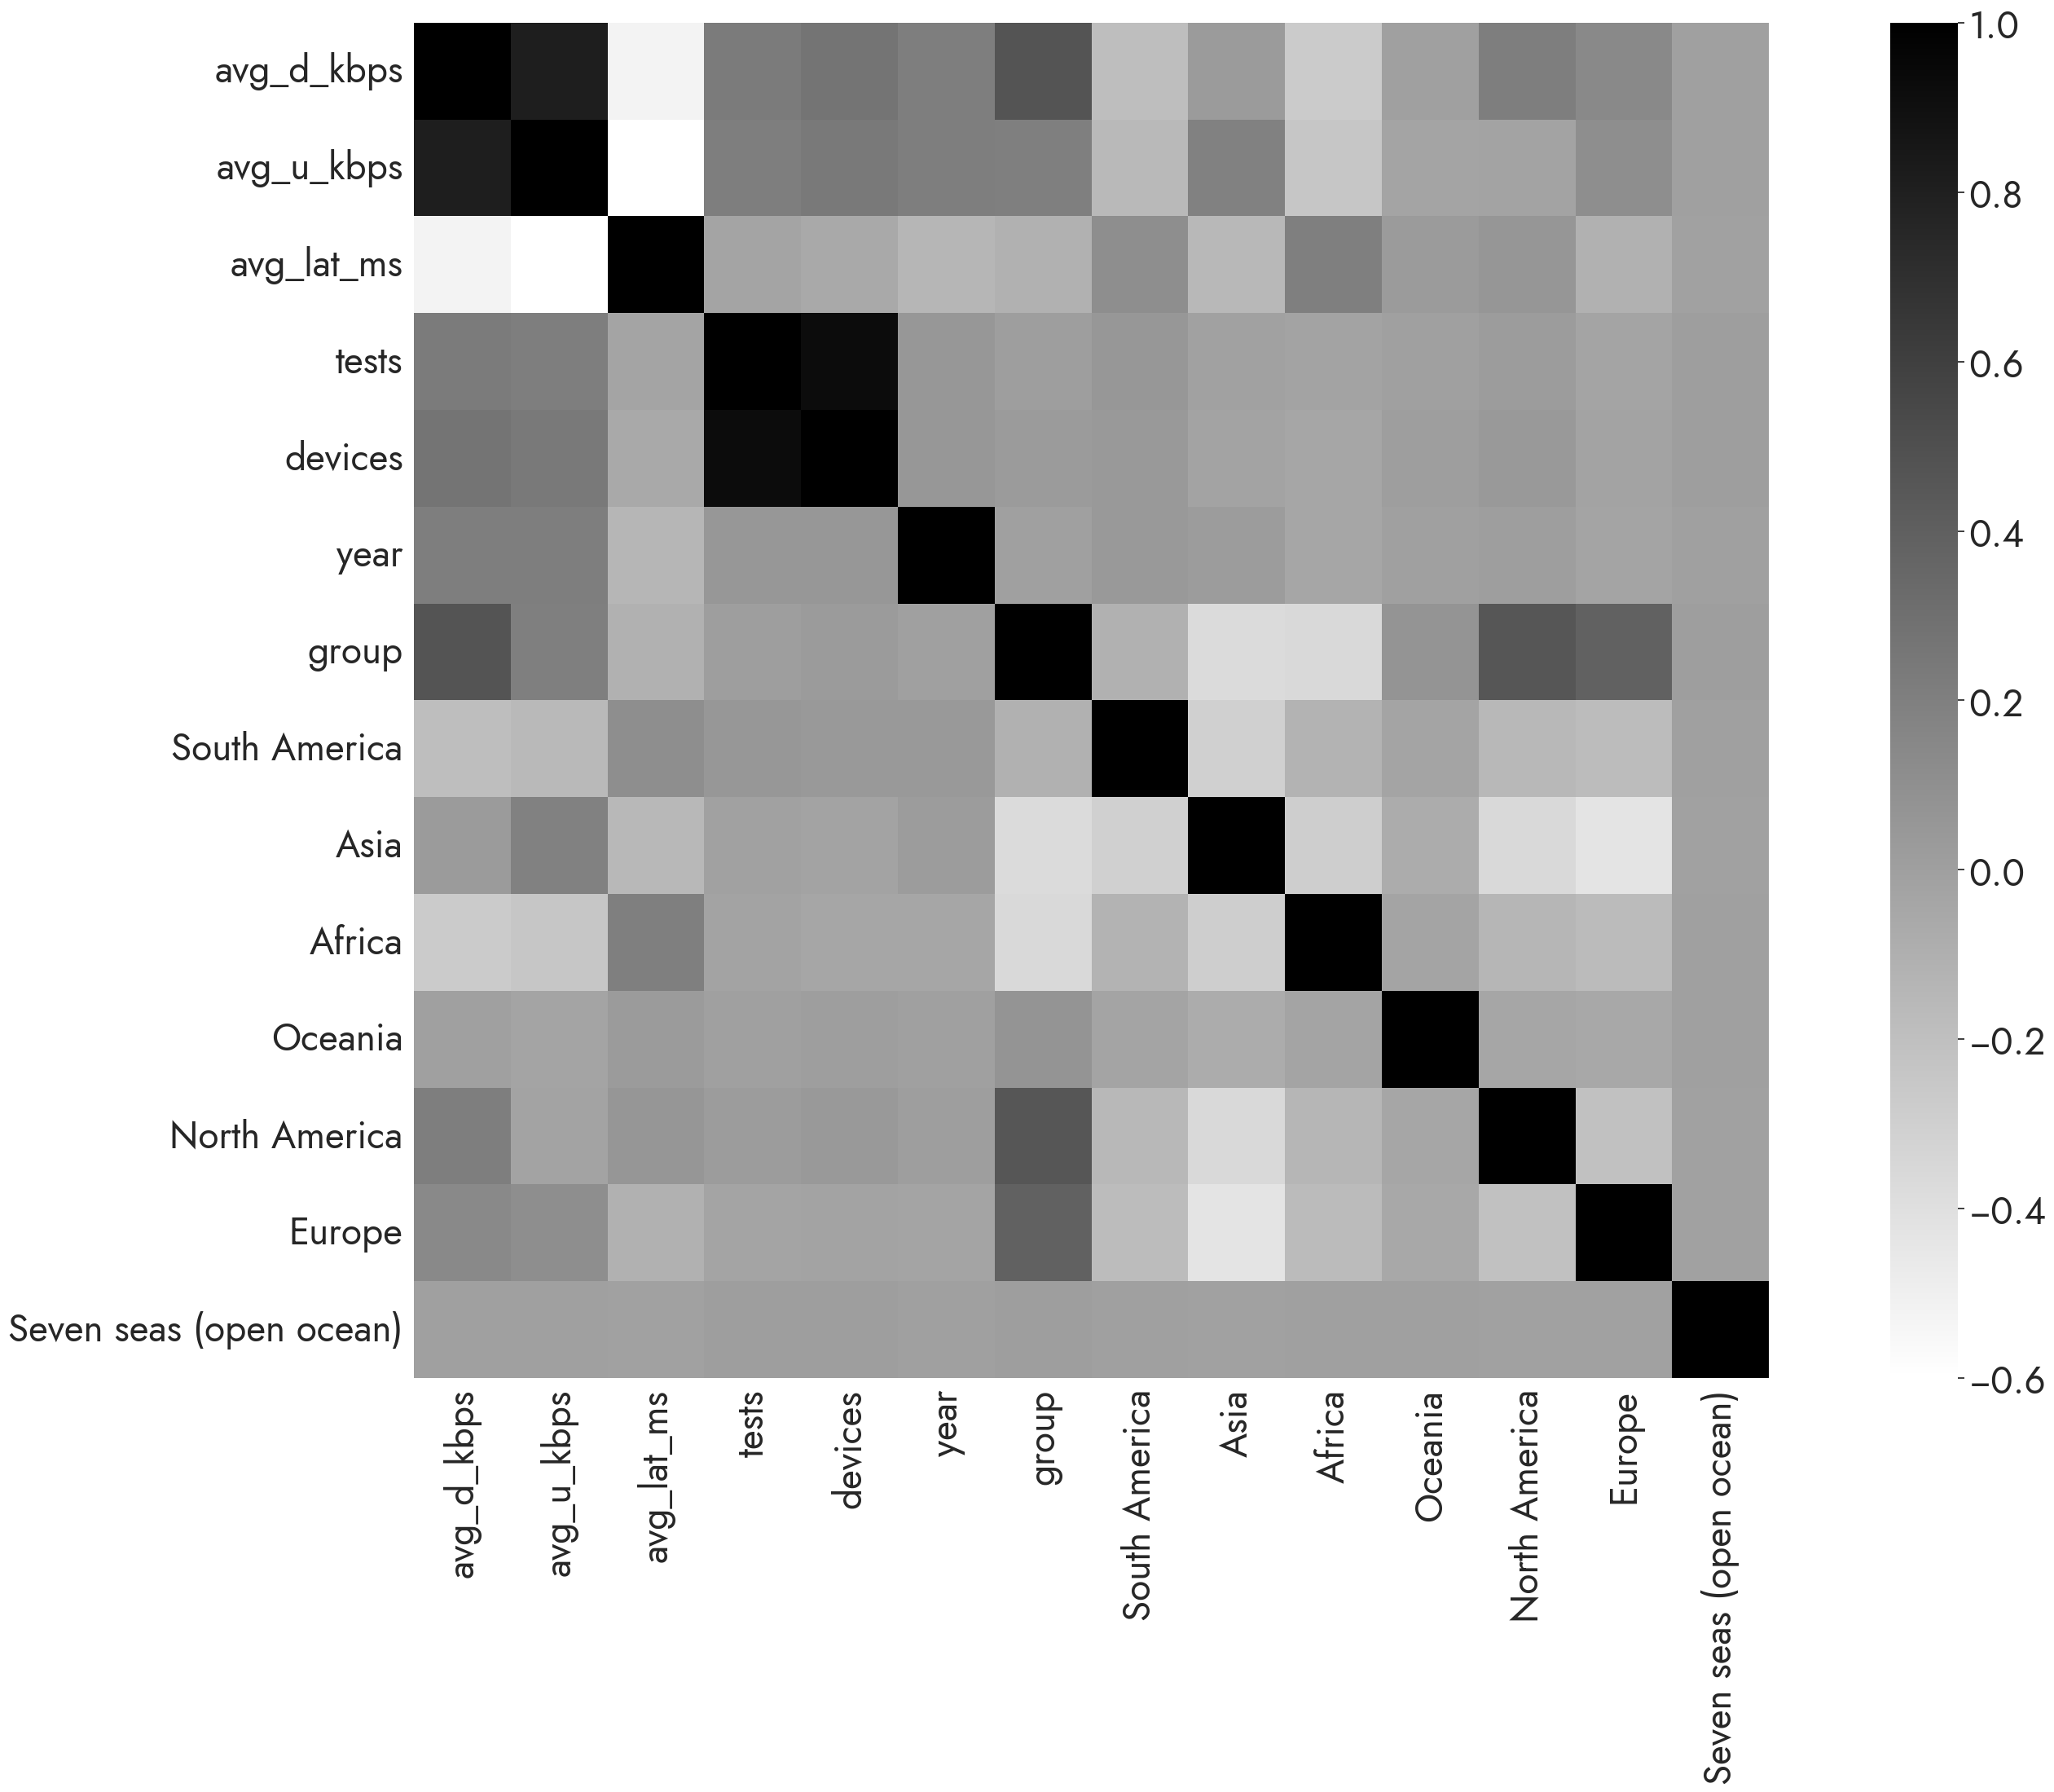

In [11]:
df_plot_corr = sns.heatmap(df_corr, cmap='gray_r', square=True);

In [12]:
df_plot_corr.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_corr.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%:

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(f'{len(train_df)} training examples')
print(f'{len(test_df)} training examples')

640000 training examples
160000 training examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную.

In [14]:
train_features = train_df.copy()
train_target = train_features.pop('group')

In [15]:
test_features = test_df.copy()
test_target = test_features.pop('group')

## Linear Machine Learning
Построим несколько моделей, основанных на линейных методах машинного обучения.

In [16]:
def fit_and_plot(model, arg: str, epochs: range | list = range(1, 101), patience: int = 5, **kwargs):
    histories = []

    for epoch in epochs:
        print(f'Epoch {epoch}/{len(epochs)}')

        epoch_model = model(**{arg: epoch}, **kwargs)
        epoch_model.fit(train_features, train_target)

        score = epoch_model.score(train_features, train_target)
        test_score = epoch_model.score(test_features, test_target)

        histories.append({'model': epoch_model, 'score': score, 'test_score': test_score})

        print(f'score: {round(score, 4)} - test_score: {round(test_score, 4)}')

        if epoch > 10 and test_score < sum(history['test_score'] for history in histories[-patience:]) / patience:
            print(f'Epoch {epoch}: early stopping')
            break

    history_plot = sns.lineplot(data=pd.DataFrame(histories)[['score', 'test_score']], linewidth=5)

    history_plot.set_xlabel('epoch')
    history_plot.set_ylabel('score')

    return max(histories, key=lambda history: history['test_score']), history_plot

### k-neighbors
Обучим модель с методом классификации k-ближайших соседей.

Epoch 1/100
score: 1.0 - test_score: 0.4031
Epoch 2/100
score: 0.7045 - test_score: 0.4156
Epoch 3/100
score: 0.6688 - test_score: 0.4295
Epoch 4/100
score: 0.6367 - test_score: 0.4416
Epoch 5/100
score: 0.6158 - test_score: 0.449
Epoch 6/100
score: 0.5983 - test_score: 0.4544
Epoch 7/100
score: 0.5892 - test_score: 0.4591
Epoch 8/100
score: 0.5797 - test_score: 0.4634
Epoch 9/100
score: 0.5733 - test_score: 0.4679
Epoch 10/100
score: 0.5673 - test_score: 0.47
Epoch 11/100
score: 0.5617 - test_score: 0.4721
Epoch 12/100
score: 0.5575 - test_score: 0.4744
Epoch 13/100
score: 0.5542 - test_score: 0.4771
Epoch 14/100
score: 0.5512 - test_score: 0.4778
Epoch 15/100
score: 0.5485 - test_score: 0.4795
Epoch 16/100
score: 0.5463 - test_score: 0.4811
Epoch 17/100
score: 0.5446 - test_score: 0.4821
Epoch 18/100
score: 0.5424 - test_score: 0.4826
Epoch 19/100
score: 0.5409 - test_score: 0.4841
Epoch 20/100
score: 0.539 - test_score: 0.4847
Epoch 21/100
score: 0.5379 - test_score: 0.4858
Epoch 22

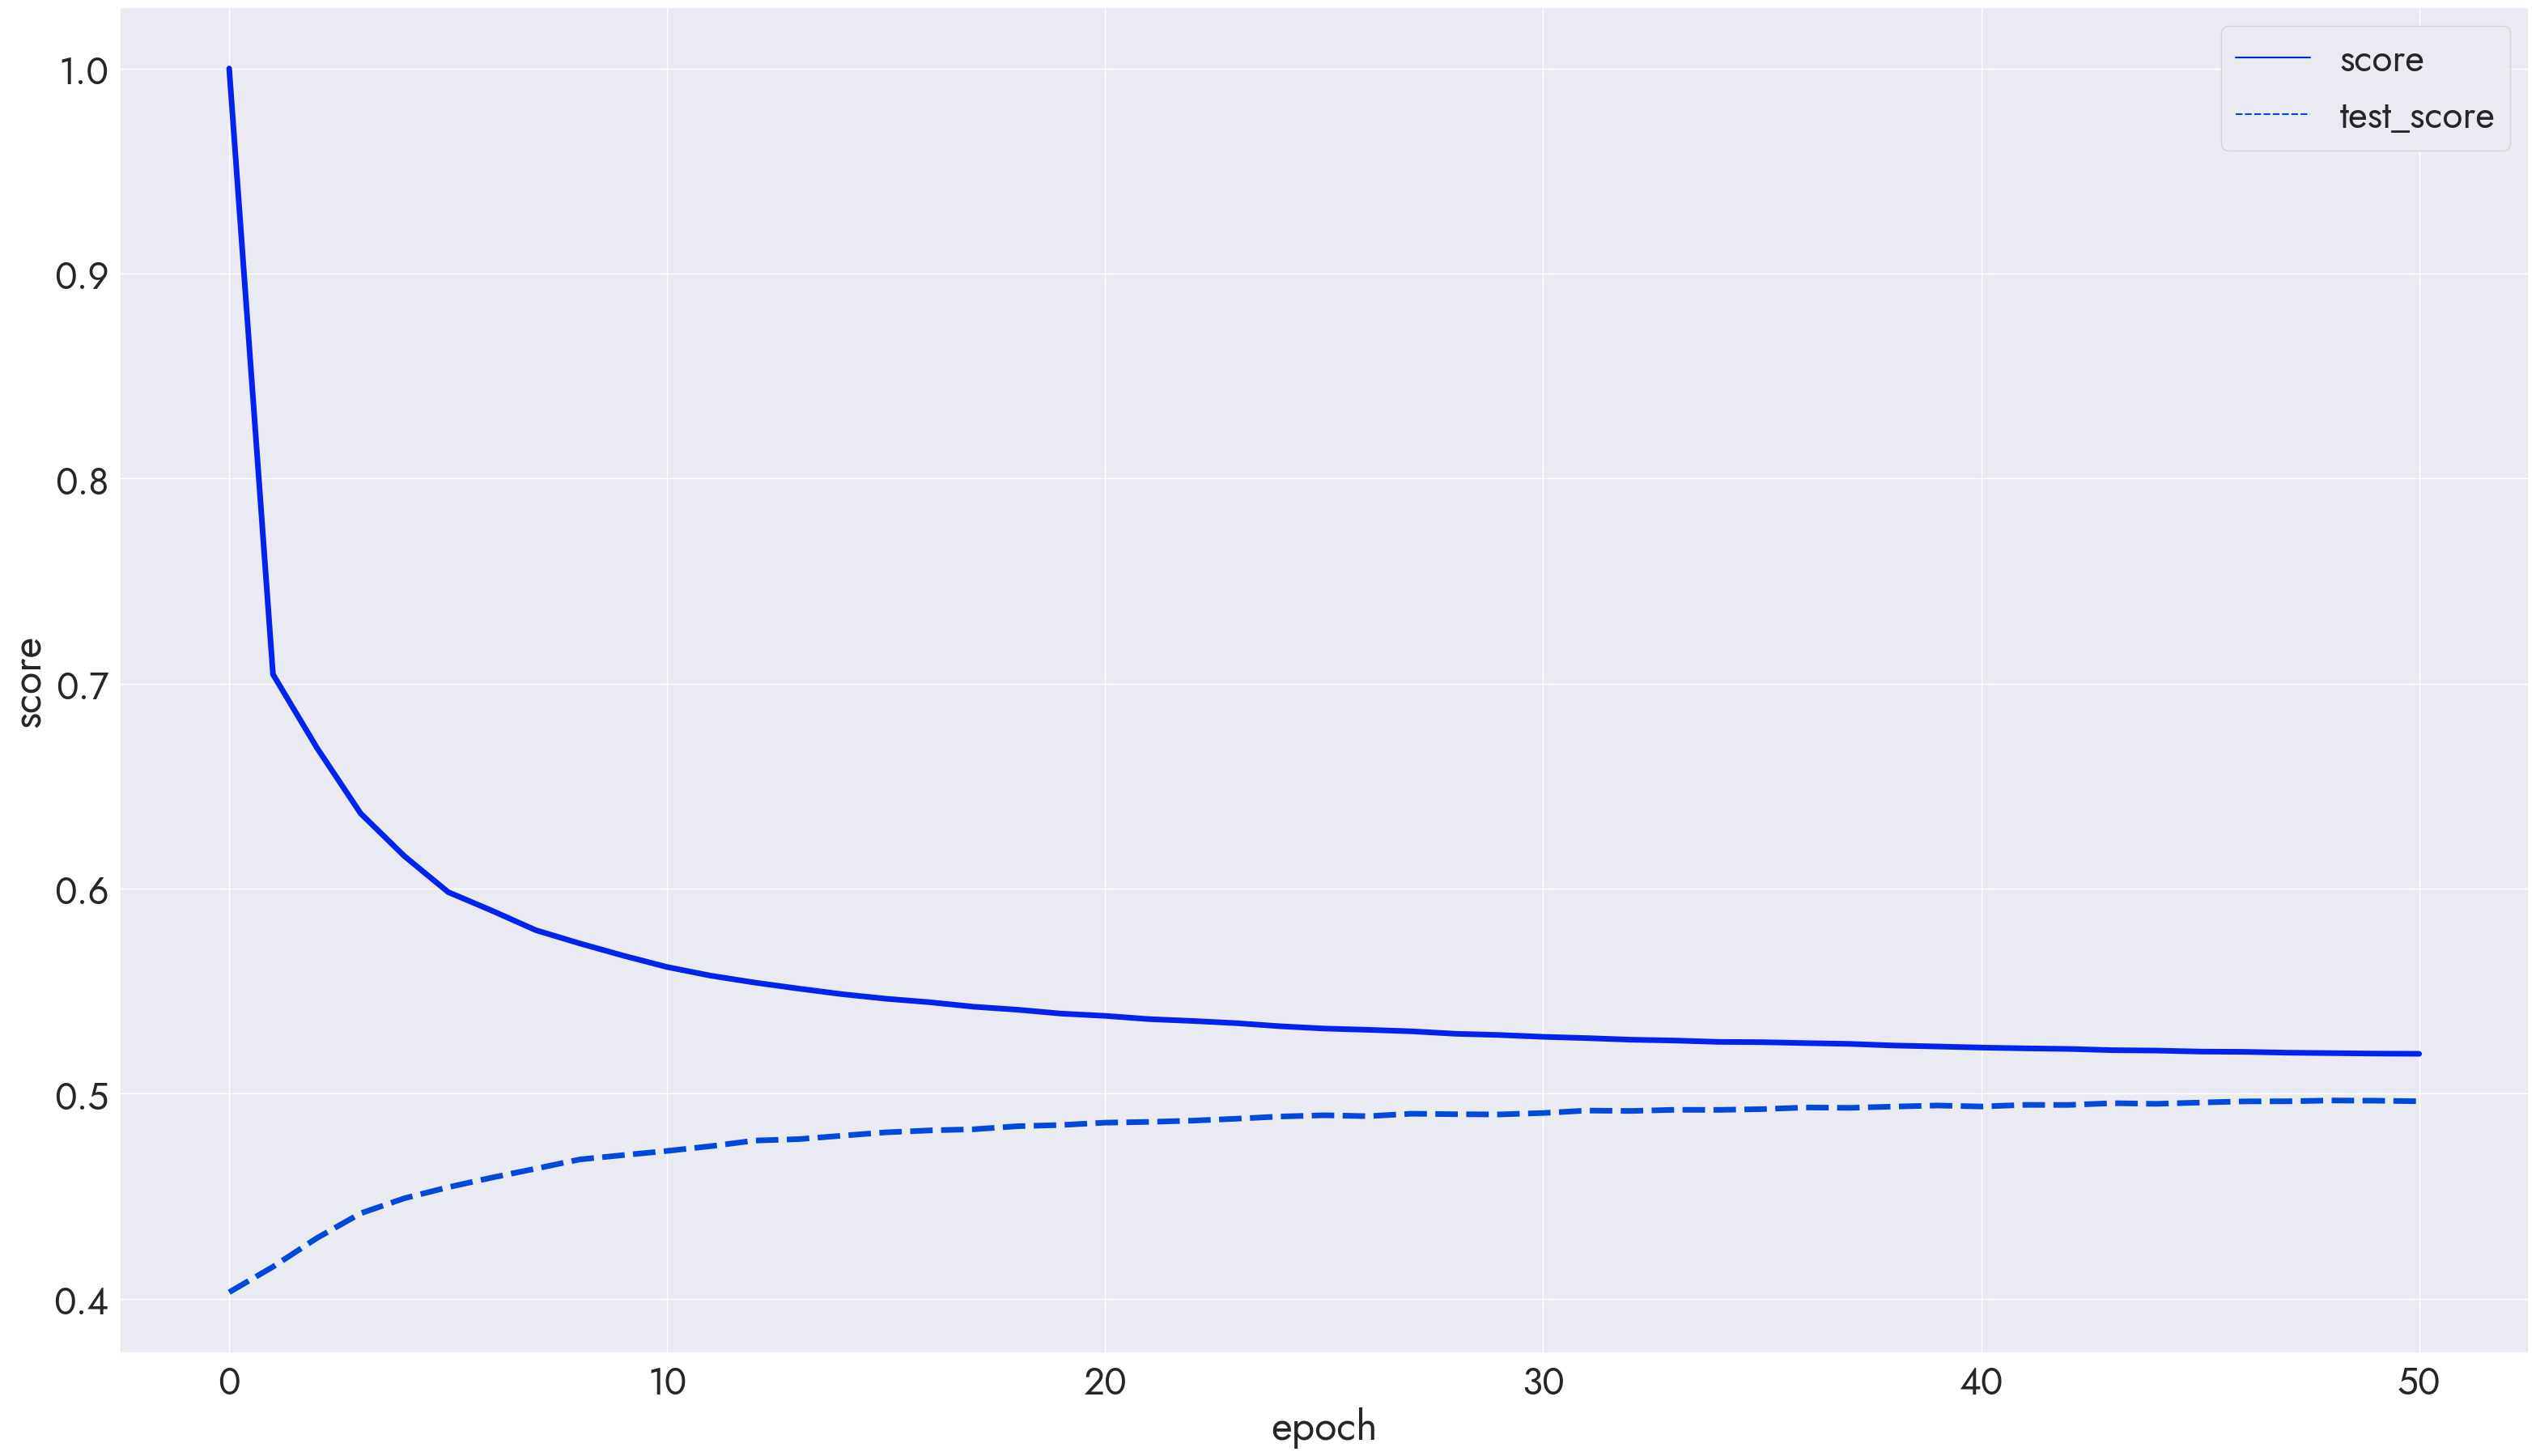

In [17]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors_model, k_neighbors_plot_history = fit_and_plot(KNeighborsClassifier, arg='n_neighbors')

In [18]:
k_neighbors_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_k_neighbors.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [19]:
print(f"score: {round(k_neighbors_model['score'], 4)}")

score: 0.5198


In [20]:
print(f"score: {round(k_neighbors_model['test_score'], 4)}")

score: 0.4966


### decision tree
Обучим модель с методом классификации дерева решений

Epoch 1/100
score: 0.3676 - test_score: 0.3682
Epoch 2/100
score: 0.4759 - test_score: 0.4747
Epoch 3/100
score: 0.5624 - test_score: 0.5608
Epoch 4/100
score: 0.6013 - test_score: 0.6009
Epoch 5/100
score: 0.6125 - test_score: 0.6138
Epoch 6/100
score: 0.6578 - test_score: 0.6583
Epoch 7/100
score: 0.6692 - test_score: 0.6686
Epoch 8/100
score: 0.6773 - test_score: 0.676
Epoch 9/100
score: 0.6871 - test_score: 0.6848
Epoch 10/100
score: 0.6958 - test_score: 0.6913
Epoch 11/100
score: 0.7043 - test_score: 0.6967
Epoch 12/100
score: 0.7119 - test_score: 0.6998
Epoch 13/100
score: 0.7211 - test_score: 0.7016
Epoch 14/100
score: 0.7313 - test_score: 0.7011
Epoch 15/100
score: 0.7433 - test_score: 0.6986
Epoch 15: early stopping


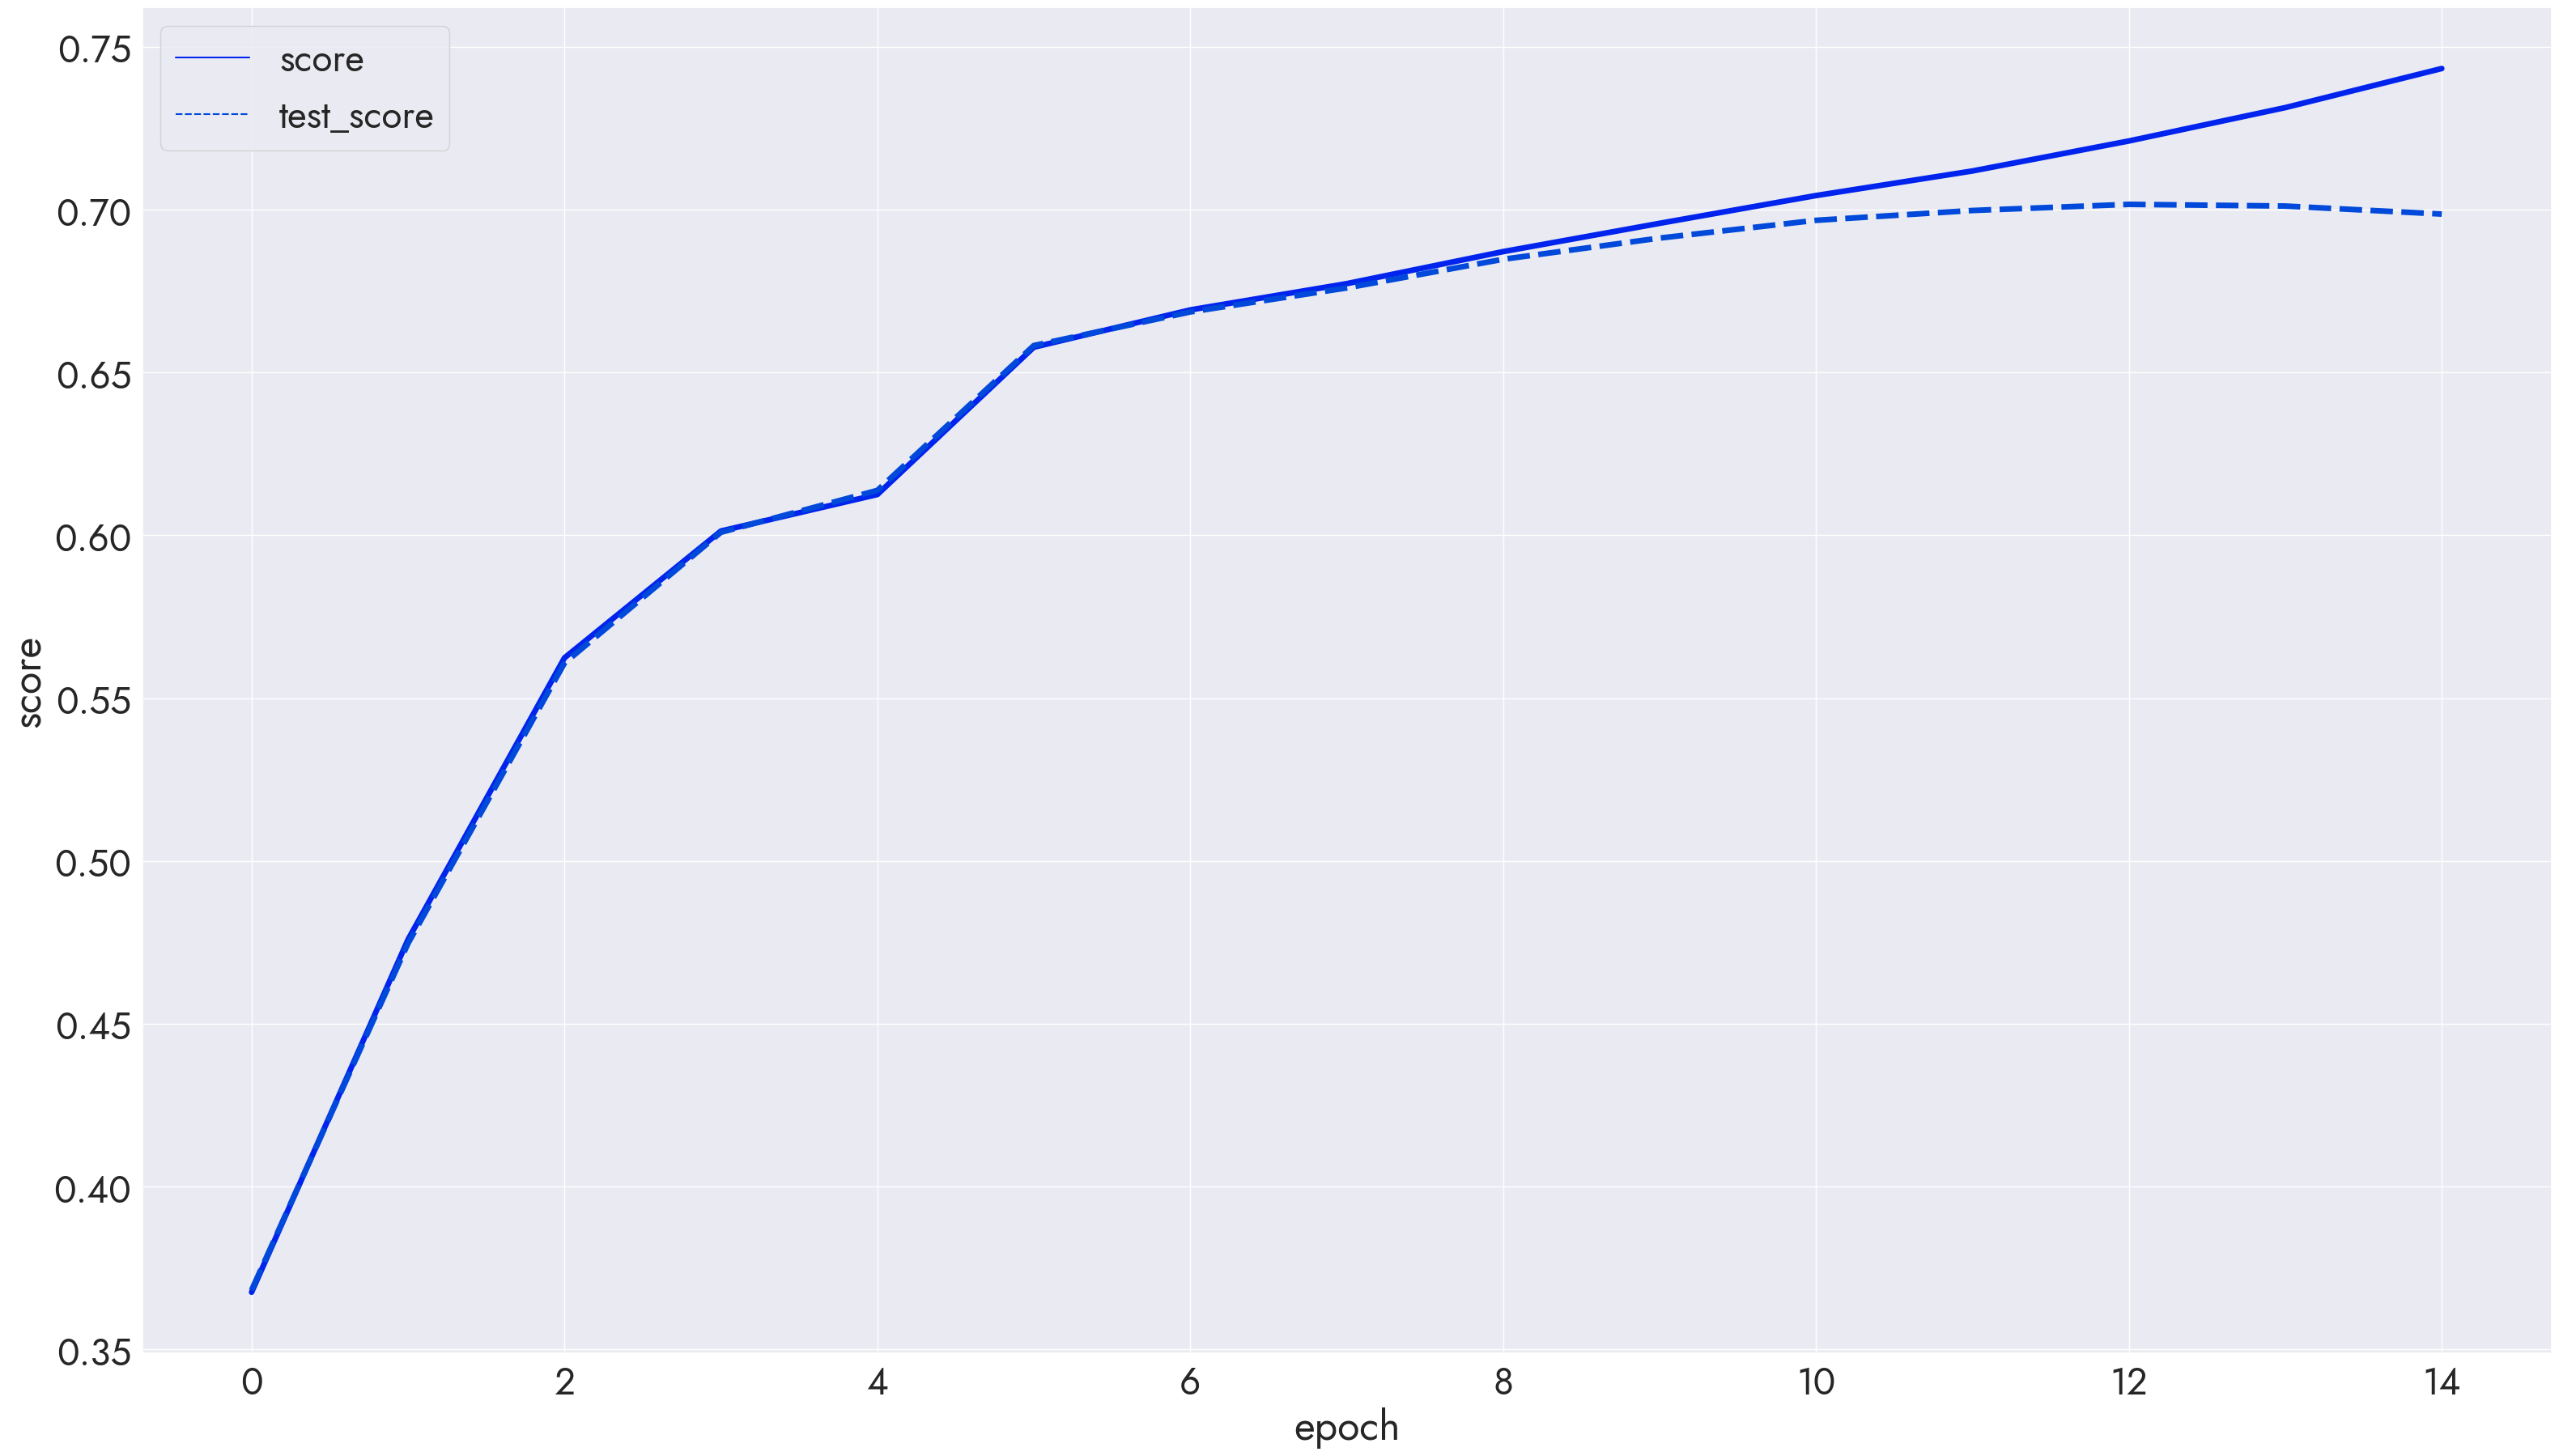

In [21]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model, decision_tree_plot_history = fit_and_plot(DecisionTreeClassifier, arg='max_depth', random_state=SEED)

In [22]:
decision_tree_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_decision_tree.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [23]:
print(f"score: {round(decision_tree_model['score'], 4)}")

score: 0.7211


In [24]:
print(f"score: {round(decision_tree_model['test_score'], 4)}")

score: 0.7016


Таким образом, предсказательная точность алгоритмической модели достаточно высокая.

### finally
Проанализируем модель, имеющую наибольшую точность предсказаний на тестовой выборке.

In [25]:
linear_model = decision_tree_model['model']

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [26]:
test_predict = pd.Series(linear_model.predict(test_features), index=test_df.index)

Рассмотрим распределение предсказаний модели по группам:

In [27]:
linear_dist = pd.DataFrame(sklearn.metrics.confusion_matrix(test_target, test_predict), index=groups, columns=groups)
linear_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,29079,8295,2149,387
Lower-middle income,9243,23329,5589,1882
Upper-middle income,3224,5472,25414,5988
High income,315,1497,3698,34439


Выведем данную таблицу на тепловую карту:

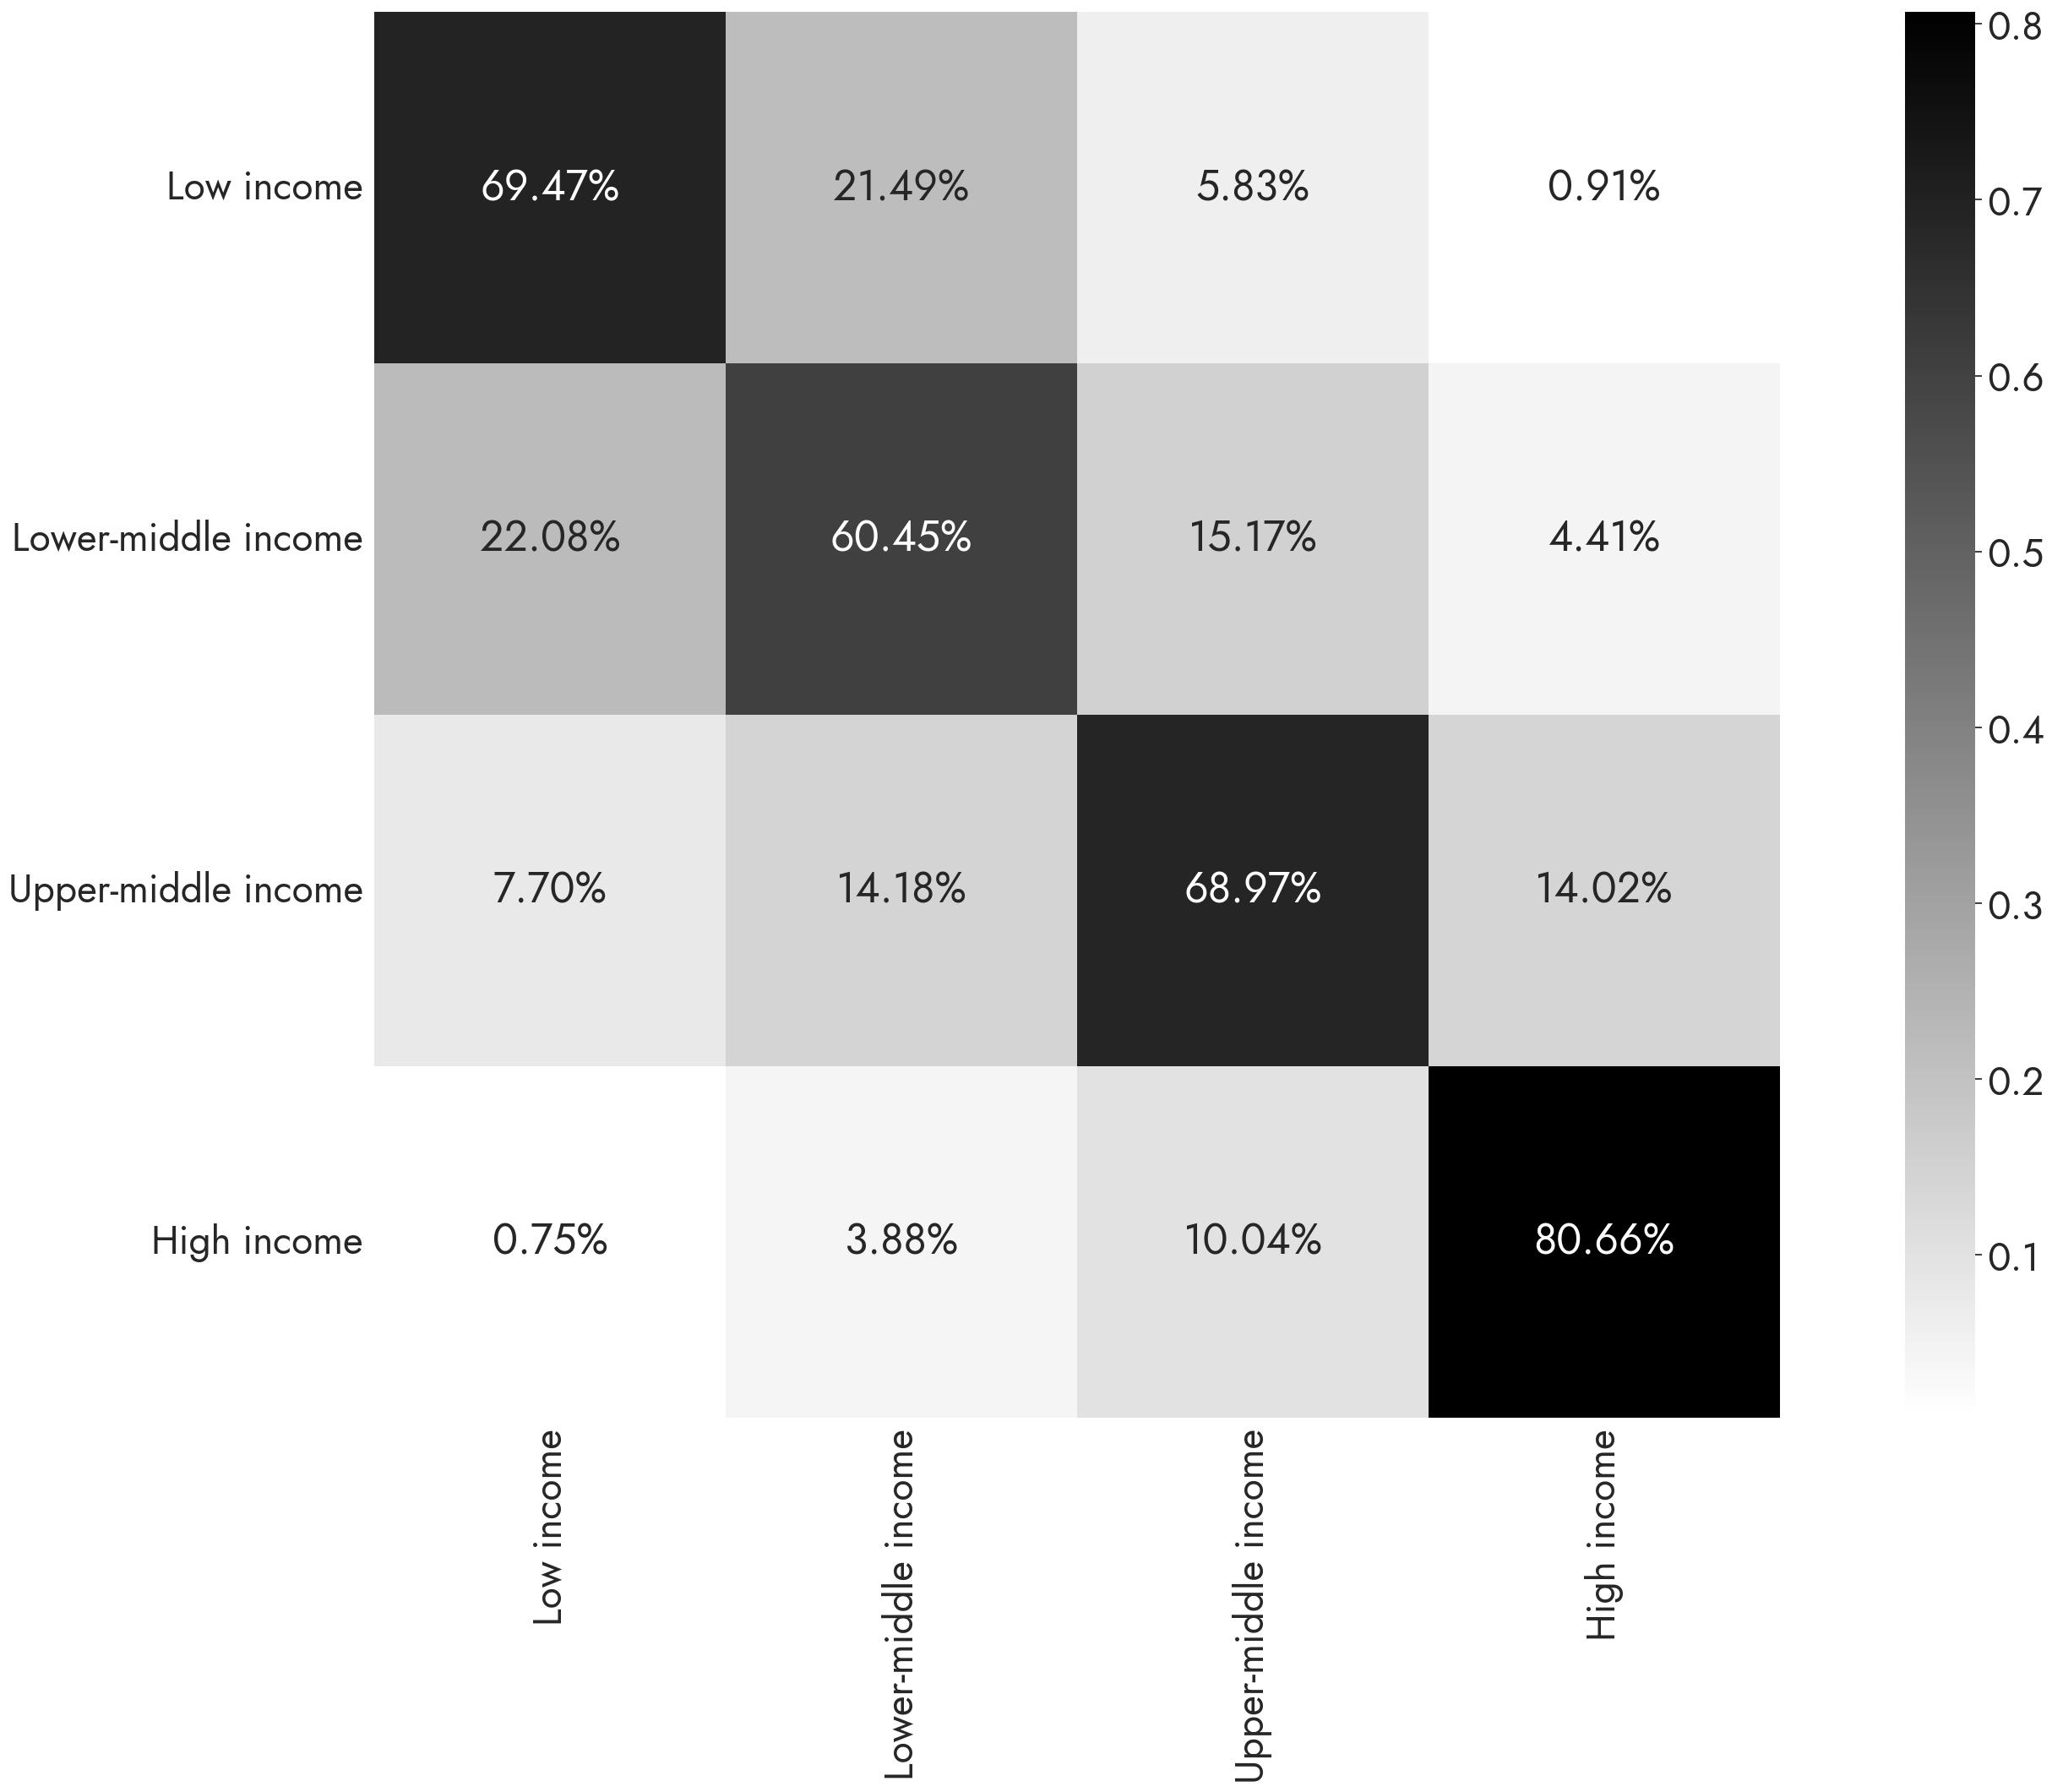

In [28]:
linear_plot_dist = sns.heatmap(linear_dist / linear_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

linear_plot_dist.set_xlabel(None);

In [29]:
linear_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_linear.png', transparent=True)

Как видно по сводной таблице и по графику, модель в большинстве случаев неверно определяет группу.
Визуализируем распределение ошибок в модели:

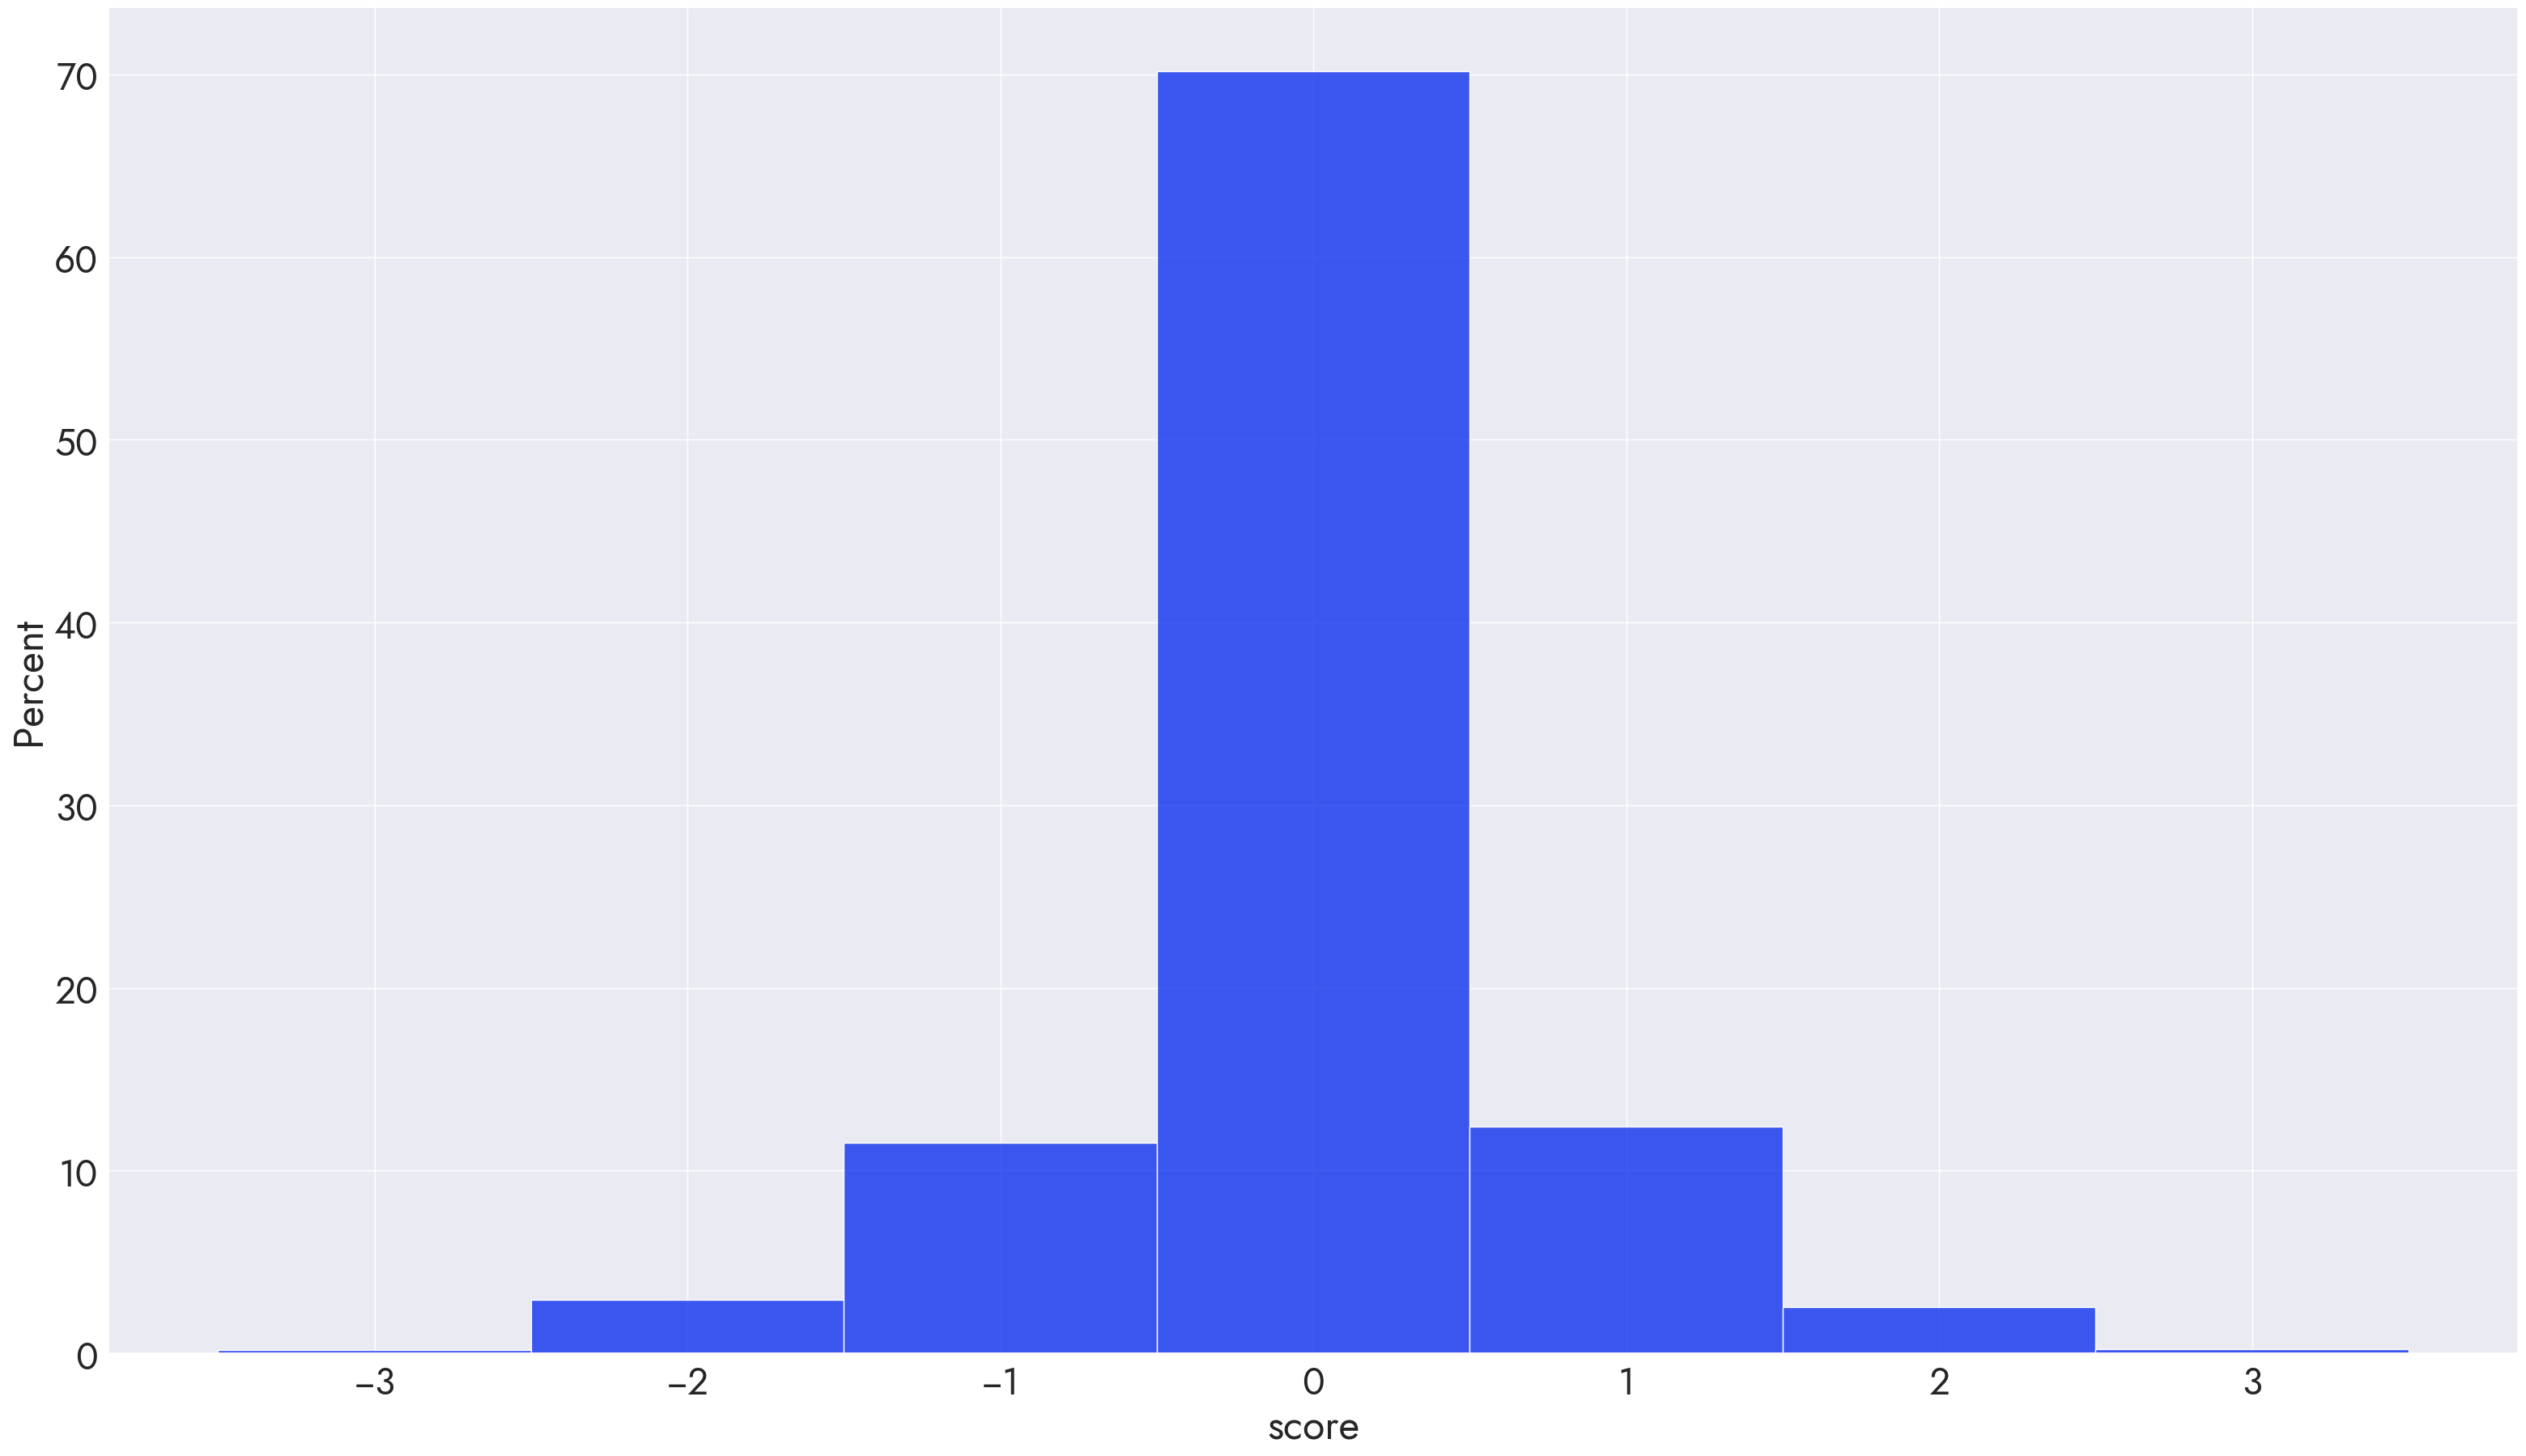

In [30]:
linear_plot_mistakes = sns.histplot(data=test_predict - test_target,
                                    stat='percent', legend=False, discrete=True)

linear_plot_mistakes.set_xlabel('mistake')
linear_plot_mistakes.set_xlabel('score');

In [31]:
linear_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_linear.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.
Однако все модели имеют тенденцию к переобучению - их точность на обучающем наборе значительно выше, чем на тестовом.

## Setting
В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [32]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 1000, patience: int = 5):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # number model loops
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, start_from_epoch=10, restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{SERIAL_TYPE}_{model.name}'),
        ],
    )

    return history.history

Для обучения моделей целевой показатель должен представлять собой dummy-переменную.
Переведём их:

In [33]:
train_target = tf.keras.utils.to_categorical(train_target, dtype='int8')
test_target = tf.keras.utils.to_categorical(test_target, dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки имеют выраженное левостороннее распределение.
Создадим слой для их нормализации:

In [34]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-28 19:29:21.696198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 19:29:21.773472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 19:29:21.773699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 19:29:21.777771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 19:29:21.777863: I tensorflow/compile

Создадим переменную, в которой будут сохраняться логи обучения моделей и их проверка на тестовом наборе:

In [35]:
train_histories = {}
test_results = {}

## Deep neural networks
Построим модели глубоких нейронных сетей (DNN).

### tiny
Обучим модель, состоящую из двух обучающих слоёв.

In [36]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [37]:
train_histories[tiny_model.name] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000


2023-05-28 19:29:34.093756: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x563693df9d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 19:29:34.093821: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-28 19:29:34.152576: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 19:29:37.236132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-28 19:29:37.526814: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-28 19:29:37.717187: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 - 17s - loss: 0.8555 - accuracy: 0.6222 - val_loss: 0.7886 - val_accuracy: 0.6514 - 17s/epoch - 8ms/step
Epoch 2/1000
2000/2000 - 9s - loss: 0.7749 - accuracy: 0.6574 - val_loss: 0.7748 - val_accuracy: 0.6644 - 9s/epoch - 4ms/step
Epoch 3/1000
2000/2000 - 9s - loss: 0.7660 - accuracy: 0.6665 - val_loss: 0.7684 - val_accuracy: 0.6717 - 9s/epoch - 4ms/step
Epoch 4/1000
2000/2000 - 9s - loss: 0.7611 - accuracy: 0.6714 - val_loss: 0.7647 - val_accuracy: 0.6756 - 9s/epoch - 4ms/step
Epoch 5/1000
2000/2000 - 9s - loss: 0.7574 - accuracy: 0.6747 - val_loss: 0.7604 - val_accuracy: 0.6770 - 9s/epoch - 5ms/step
Epoch 6/1000
2000/2000 - 8s - loss: 0.7541 - accuracy: 0.6773 - val_loss: 0.7596 - val_accuracy: 0.6714 - 8s/epoch - 4ms/step
Epoch 7/1000
2000/2000 - 8s - loss: 0.7511 - accuracy: 0.6788 - val_loss: 0.7543 - val_accuracy: 0.6795 - 8s/epoch - 4ms/step
Epoch 8/1000
2000/2000 - 8s - loss: 0.7483 - accuracy: 0.6803 - val_loss: 0.7529 - val_accuracy: 0.6817 - 8s/epoch - 4ms/step
Epo

Визуализируем ход обучения:

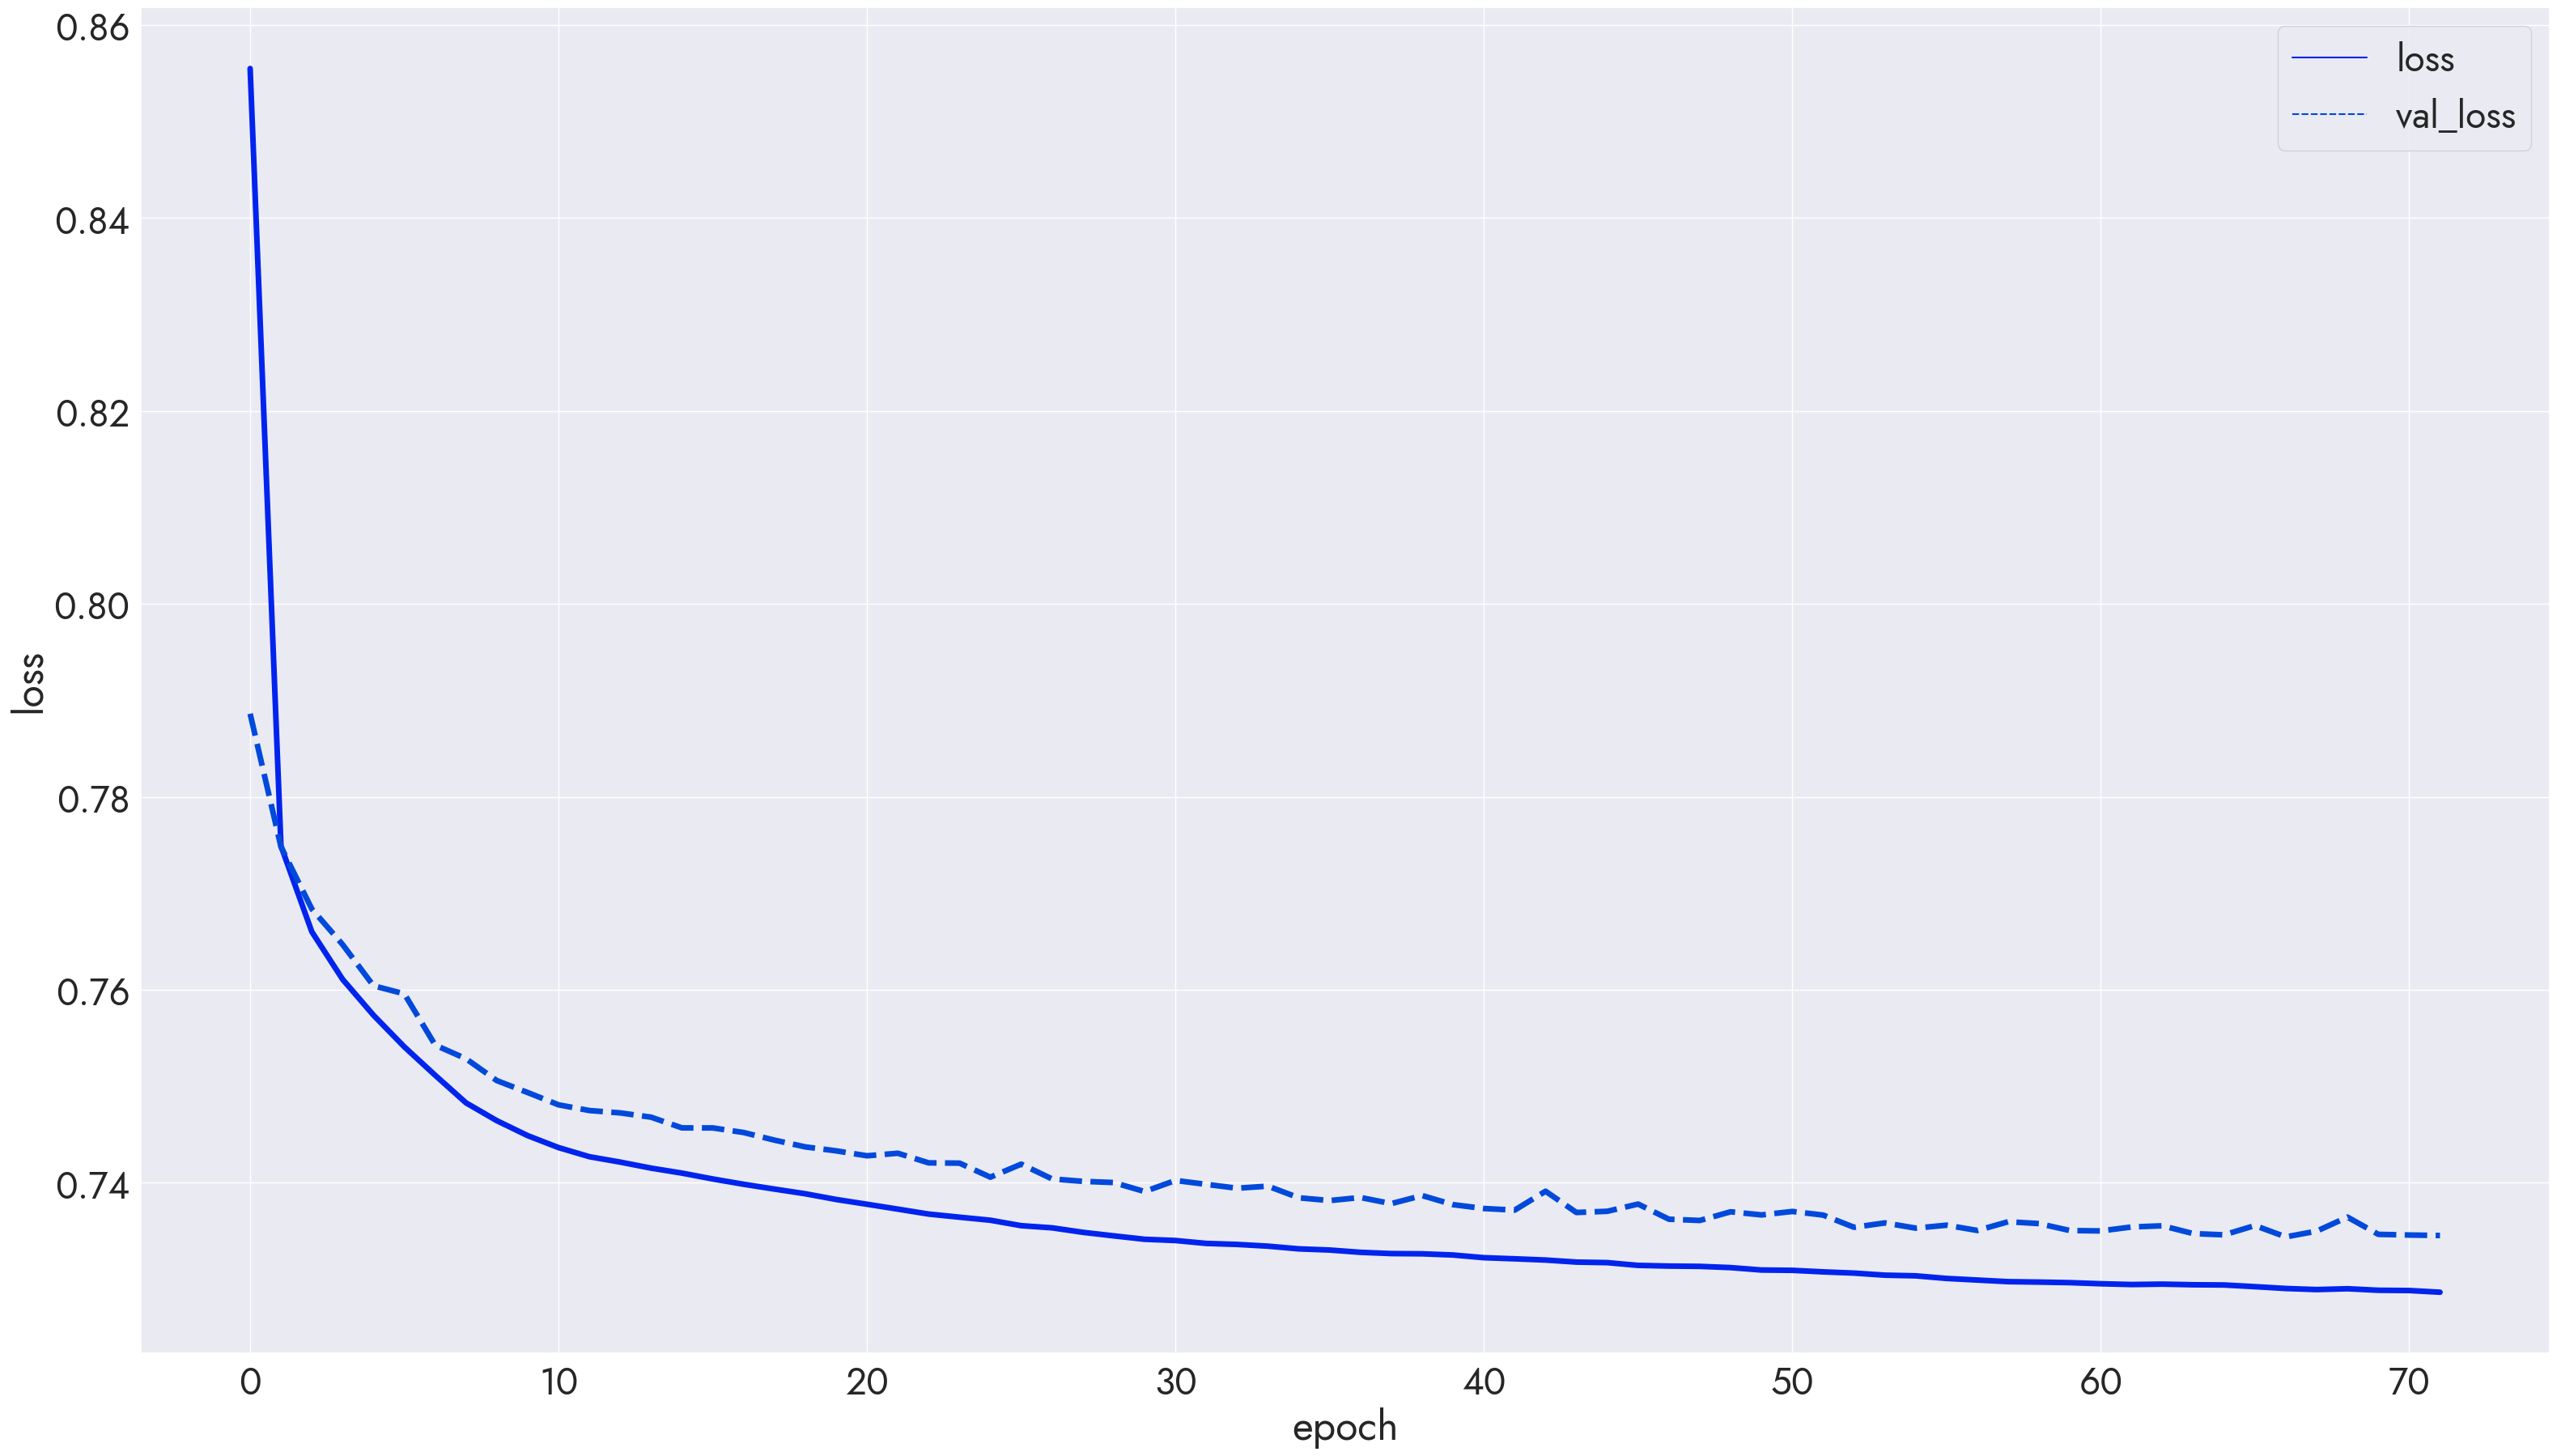

In [38]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[tiny_model.name])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('epoch')
tiny_plot_history.set_ylabel('loss');

In [39]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{tiny_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [40]:
tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

2500/2500 - 8s - loss: 0.7294 - accuracy: 0.6880 - 8s/epoch - 3ms/step


In [41]:
test_results[tiny_model.name] = tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

625/625 - 2s - loss: 0.7306 - accuracy: 0.6884 - 2s/epoch - 3ms/step


Сохраним обученную модель:

In [42]:
tiny_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{tiny_model.name}')

INFO:tensorflow:Assets written to: model/merged/fixed/fixed_tiny/assets


2023-05-28 19:40:28 - tensorflow - INFO - Assets written to: model/merged/fixed/fixed_tiny/assets


### small
Обучим модель, состоящую из трёх обучающих слоёв.

In [43]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [44]:
train_histories[small_model.name] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                448       
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,663
Trainable params: 1,636
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000
2000/2000 - 10s - loss: 0.7871 - accuracy: 0.6657 - val_loss: 0.7458 - val_accuracy: 0.6860 - 10s/epoch - 5ms/s

Визуализируем ход обучения:

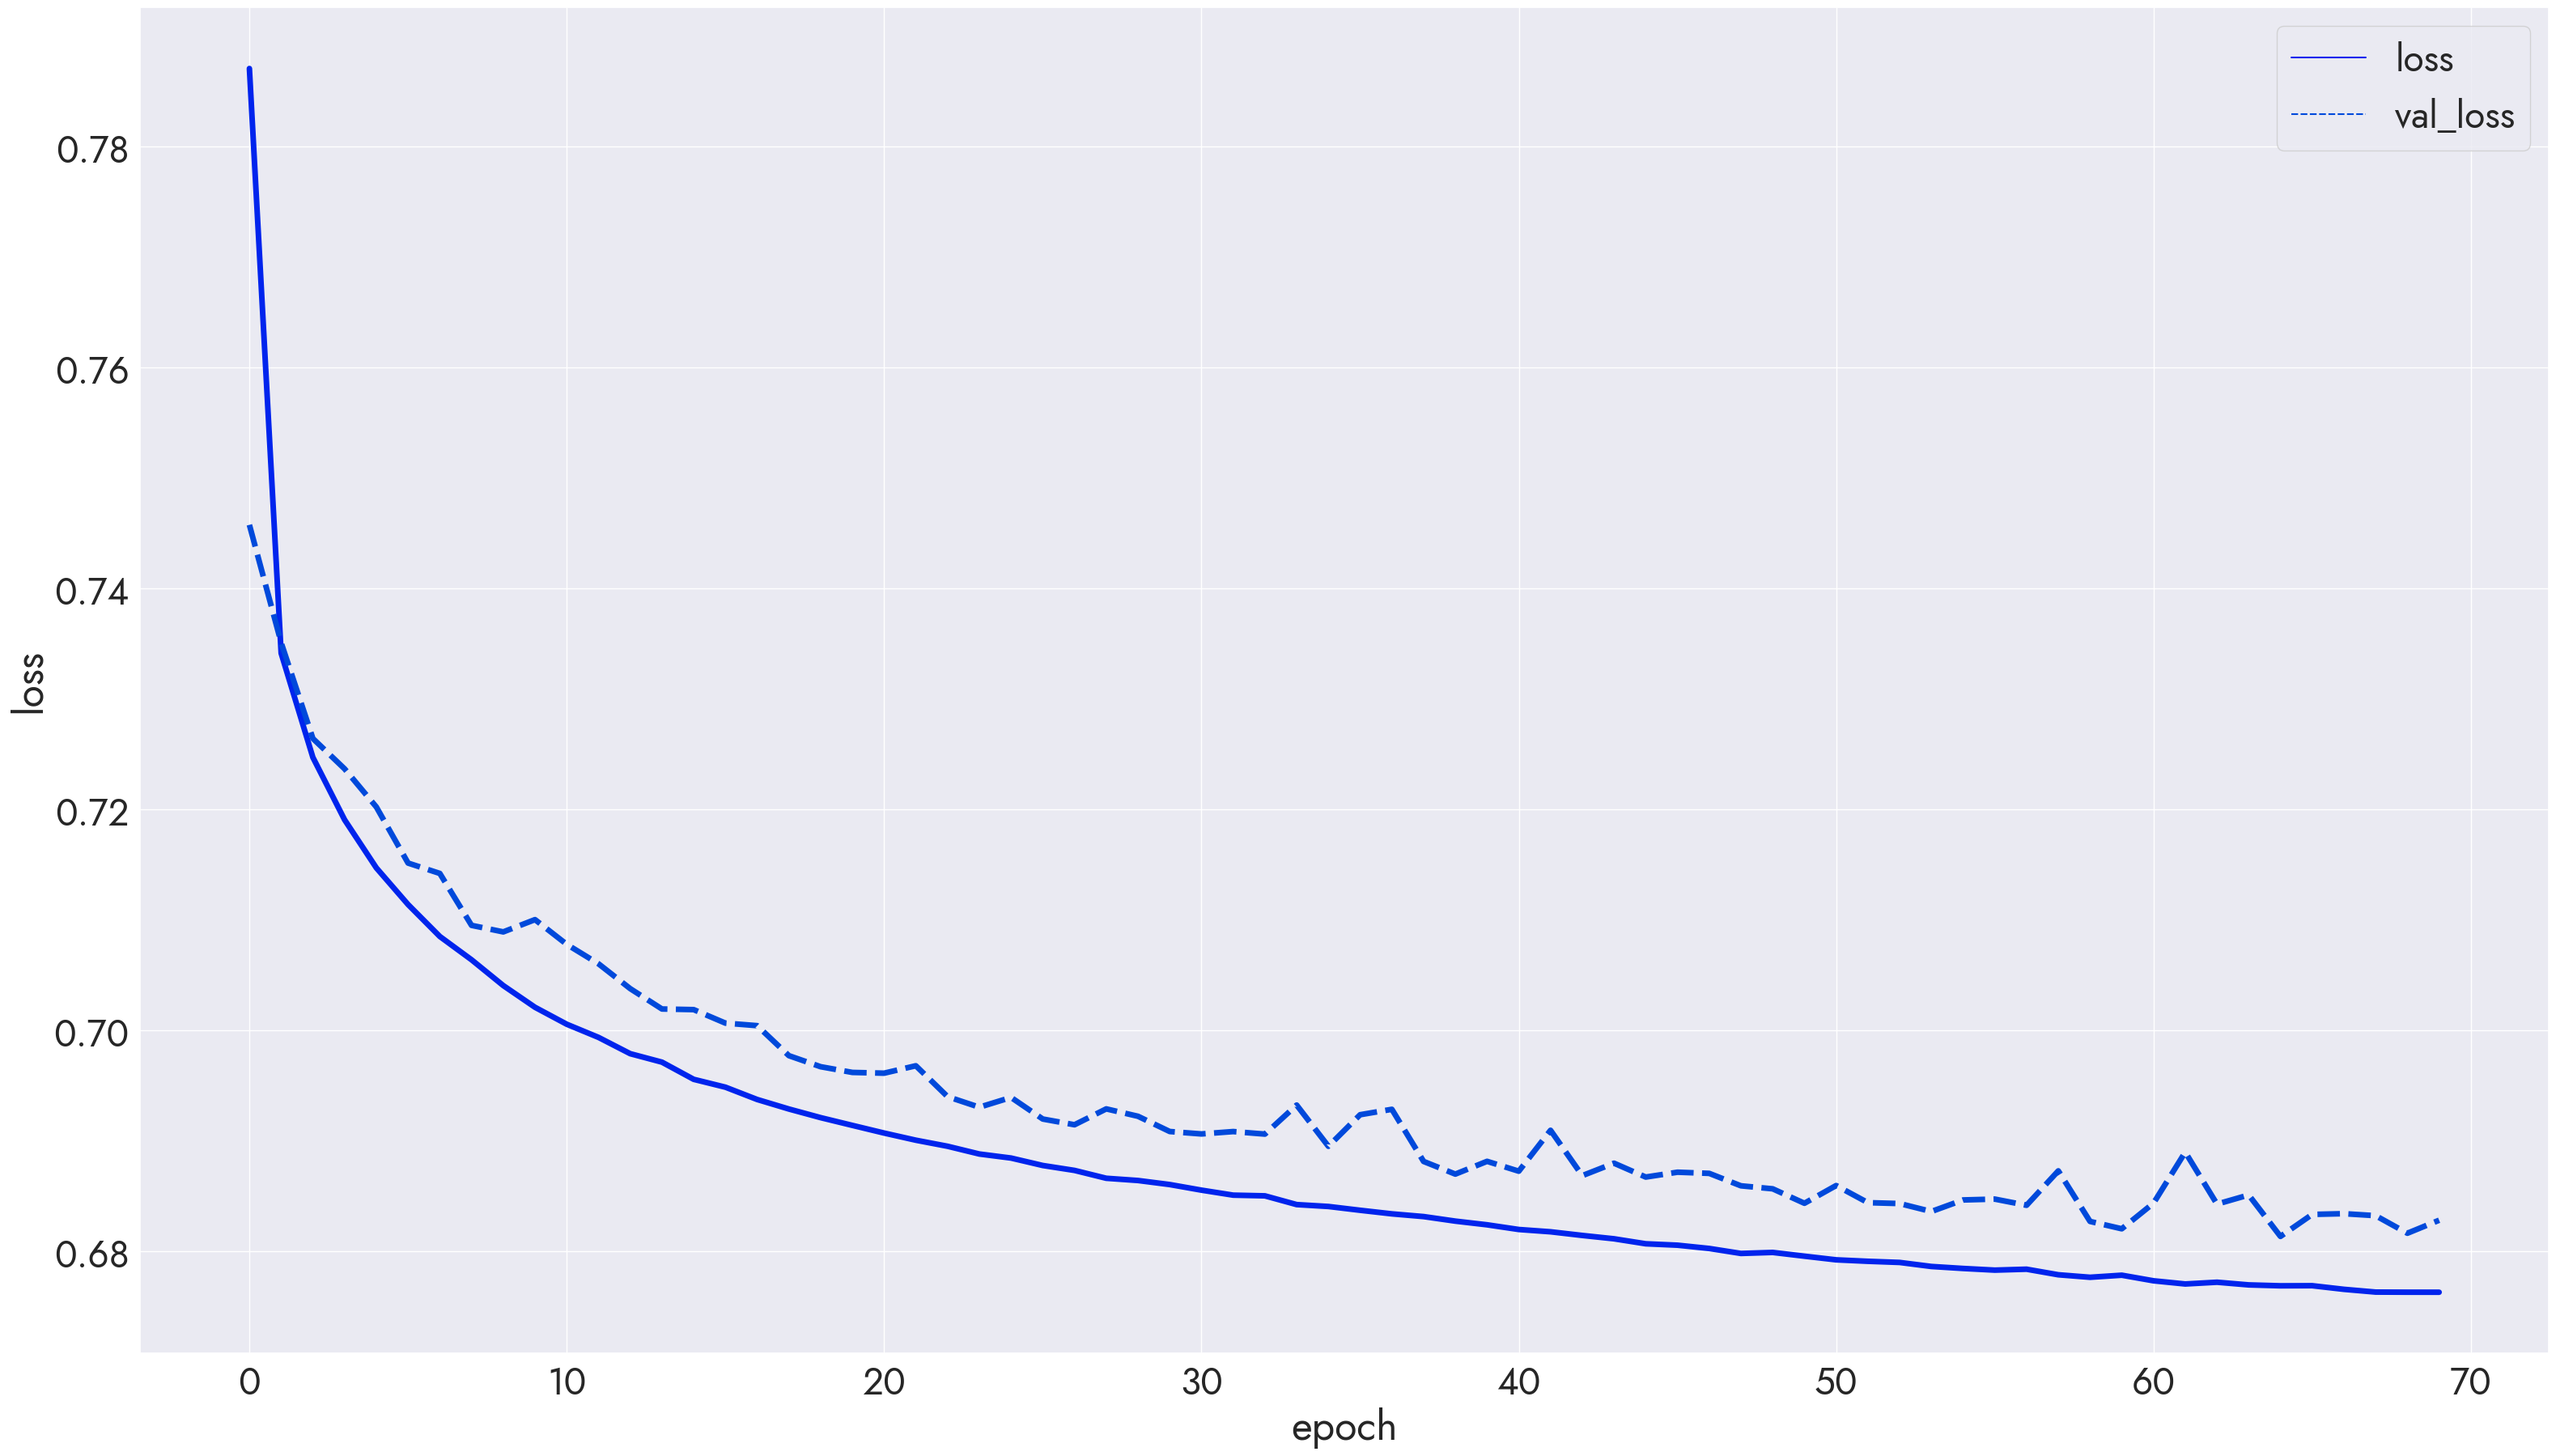

In [45]:
small_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[small_model.name])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('epoch')
small_plot_history.set_ylabel('loss');

In [46]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{small_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [47]:
small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

2500/2500 - 8s - loss: 0.6754 - accuracy: 0.7064 - 8s/epoch - 3ms/step


In [48]:
test_results[small_model.name] = small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

625/625 - 2s - loss: 0.6788 - accuracy: 0.7053 - 2s/epoch - 3ms/step


Сохраним модель:

In [49]:
small_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{small_model.name}')

INFO:tensorflow:Assets written to: model/merged/fixed/fixed_small/assets


2023-05-28 19:51:16 - tensorflow - INFO - Assets written to: model/merged/fixed/fixed_small/assets


### medium
Обучим модель, состоящую из трёх обучающих слоёв.

In [50]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [51]:
train_histories[medium_model.name] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения:

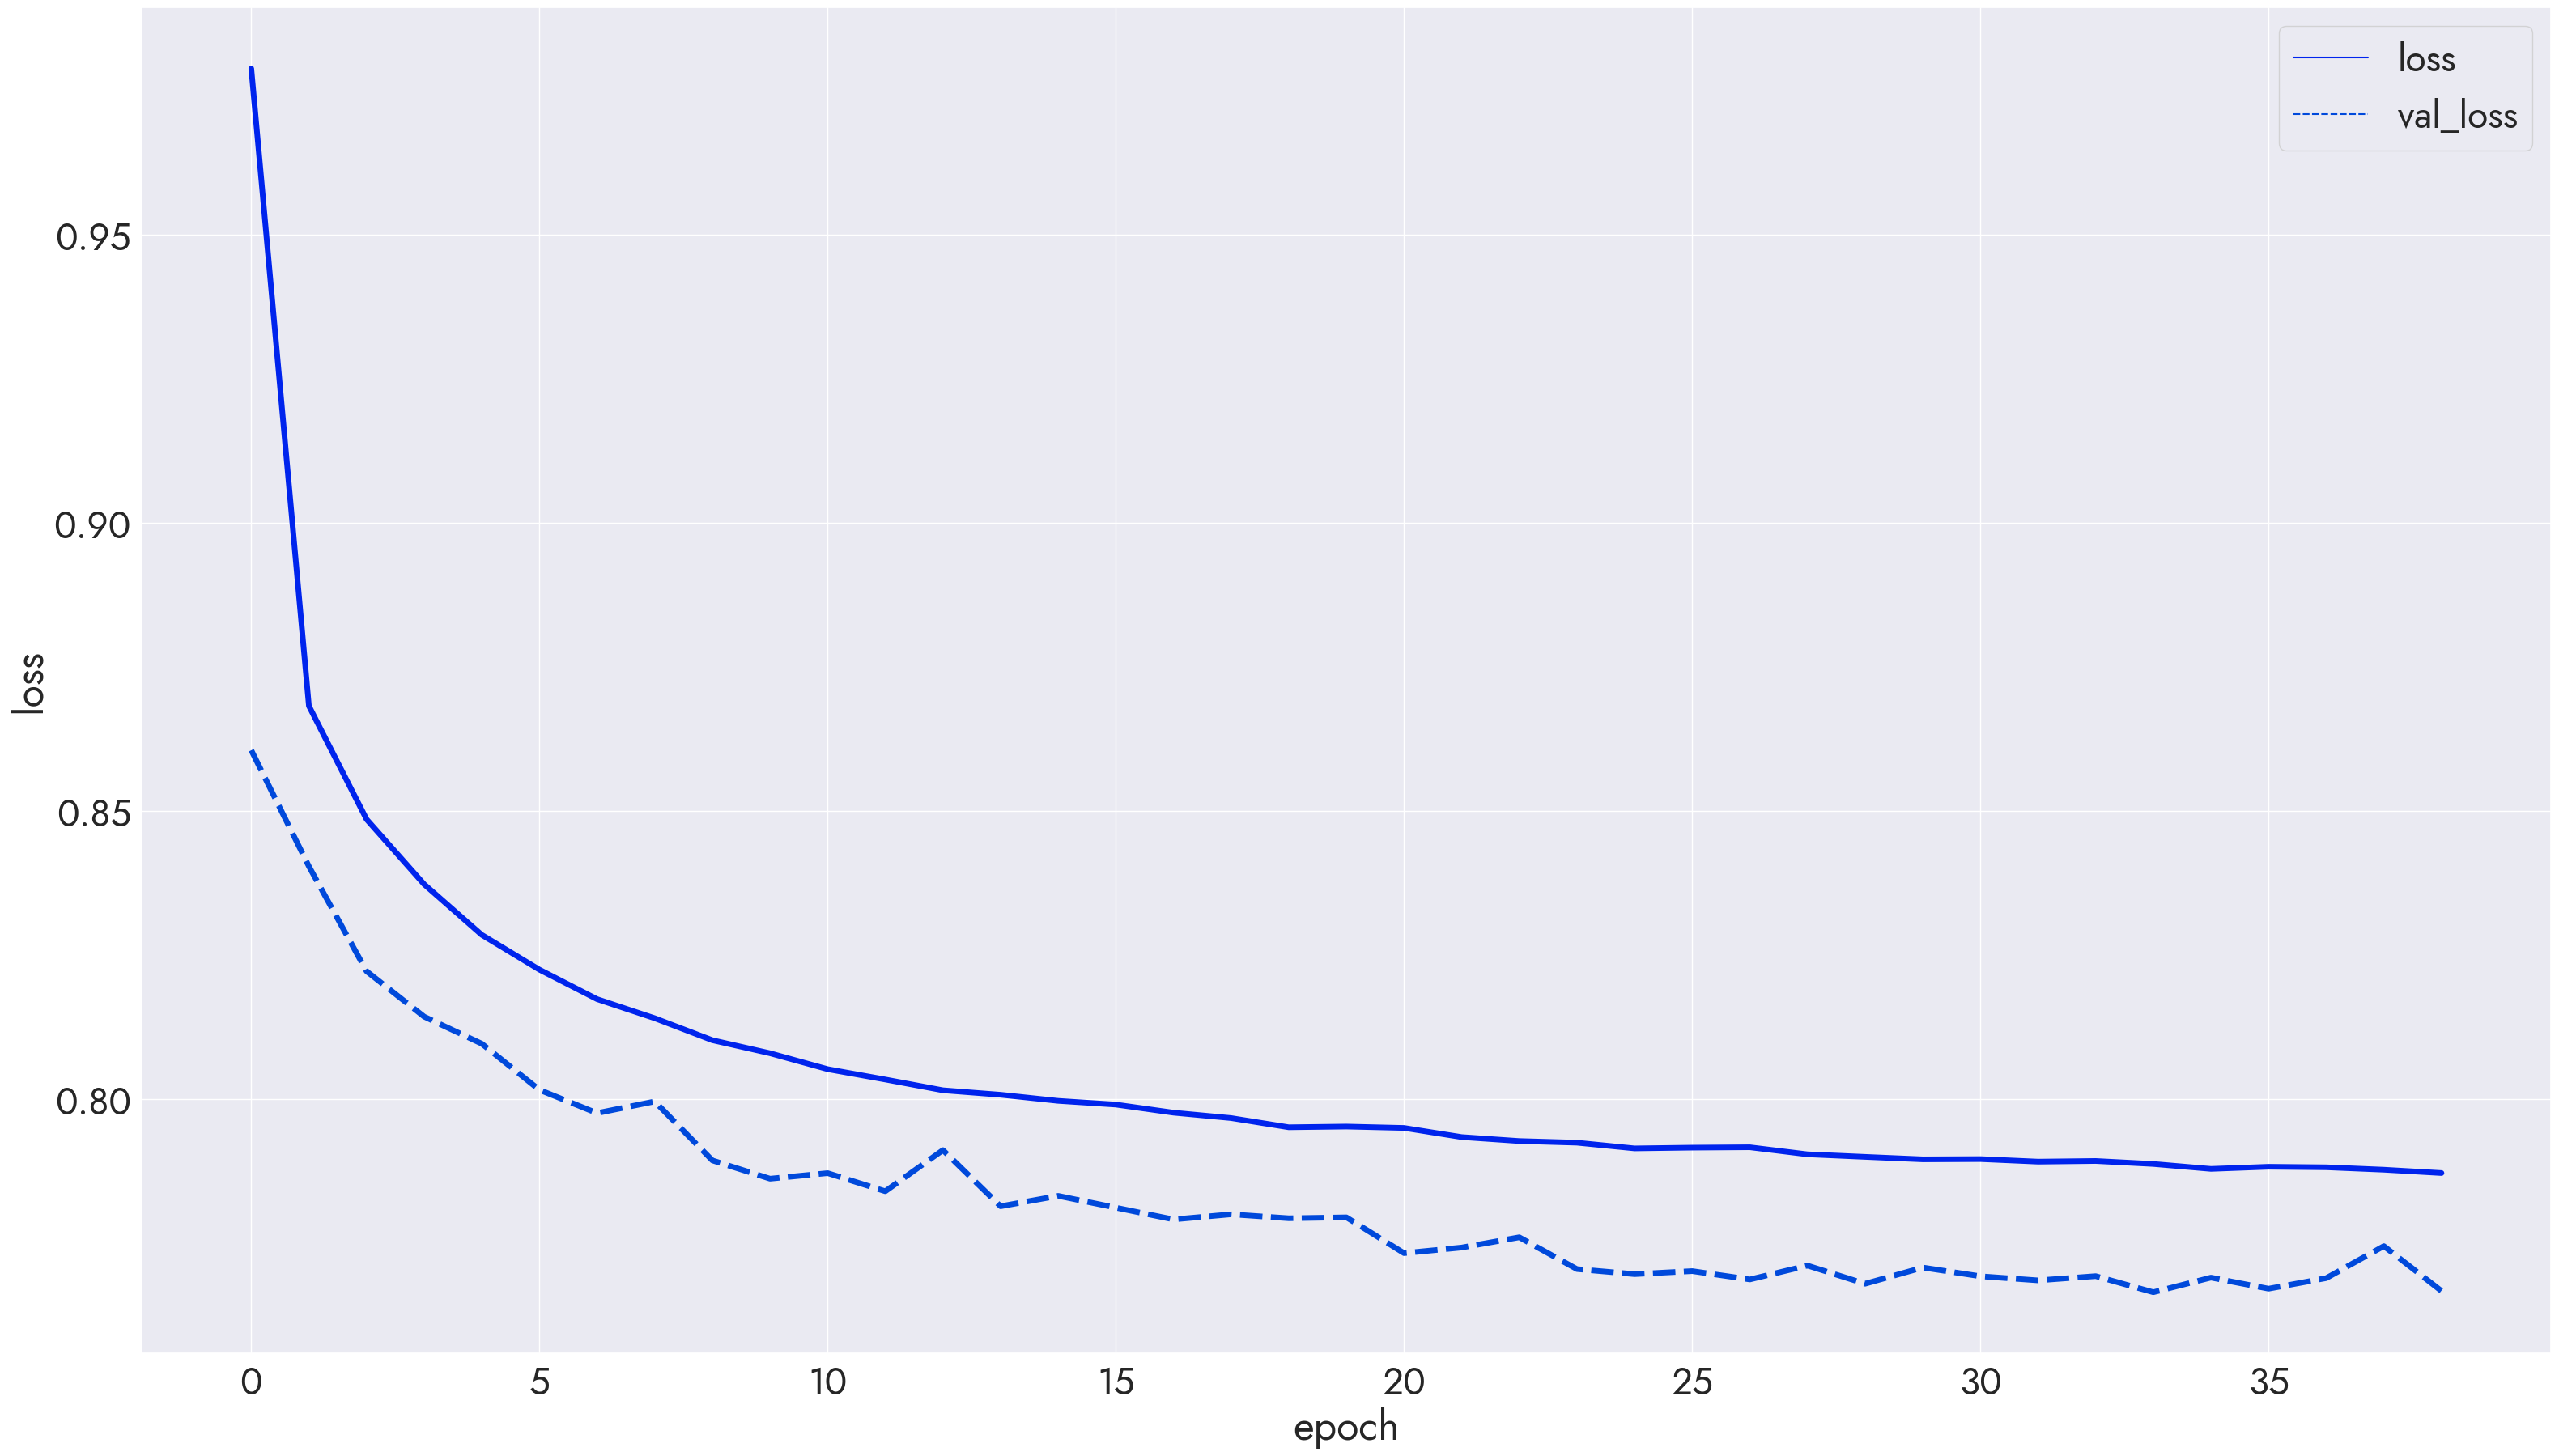

In [52]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[medium_model.name])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('epoch')
medium_plot_history.set_ylabel('loss');

In [53]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{medium_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [54]:
medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

2500/2500 - 8s - loss: 0.7623 - accuracy: 0.6858 - 8s/epoch - 3ms/step


In [55]:
test_results[medium_model.name] = medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

625/625 - 2s - loss: 0.7639 - accuracy: 0.6860 - 2s/epoch - 3ms/step


Сохраним модель:

In [56]:
medium_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{medium_model.name}')

2023-05-28 19:59:59.619755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-28 19:59:59.813513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/merged/fixed/fixed_medium/assets


2023-05-28 20:00:00 - tensorflow - INFO - Assets written to: model/merged/fixed/fixed_medium/assets


### large
Обучим модель, состоящую из шести обучающих слоёв.

In [57]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [58]:
train_histories[large_model.name] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 256)               3584      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                             

Визуализируем ход обучения:

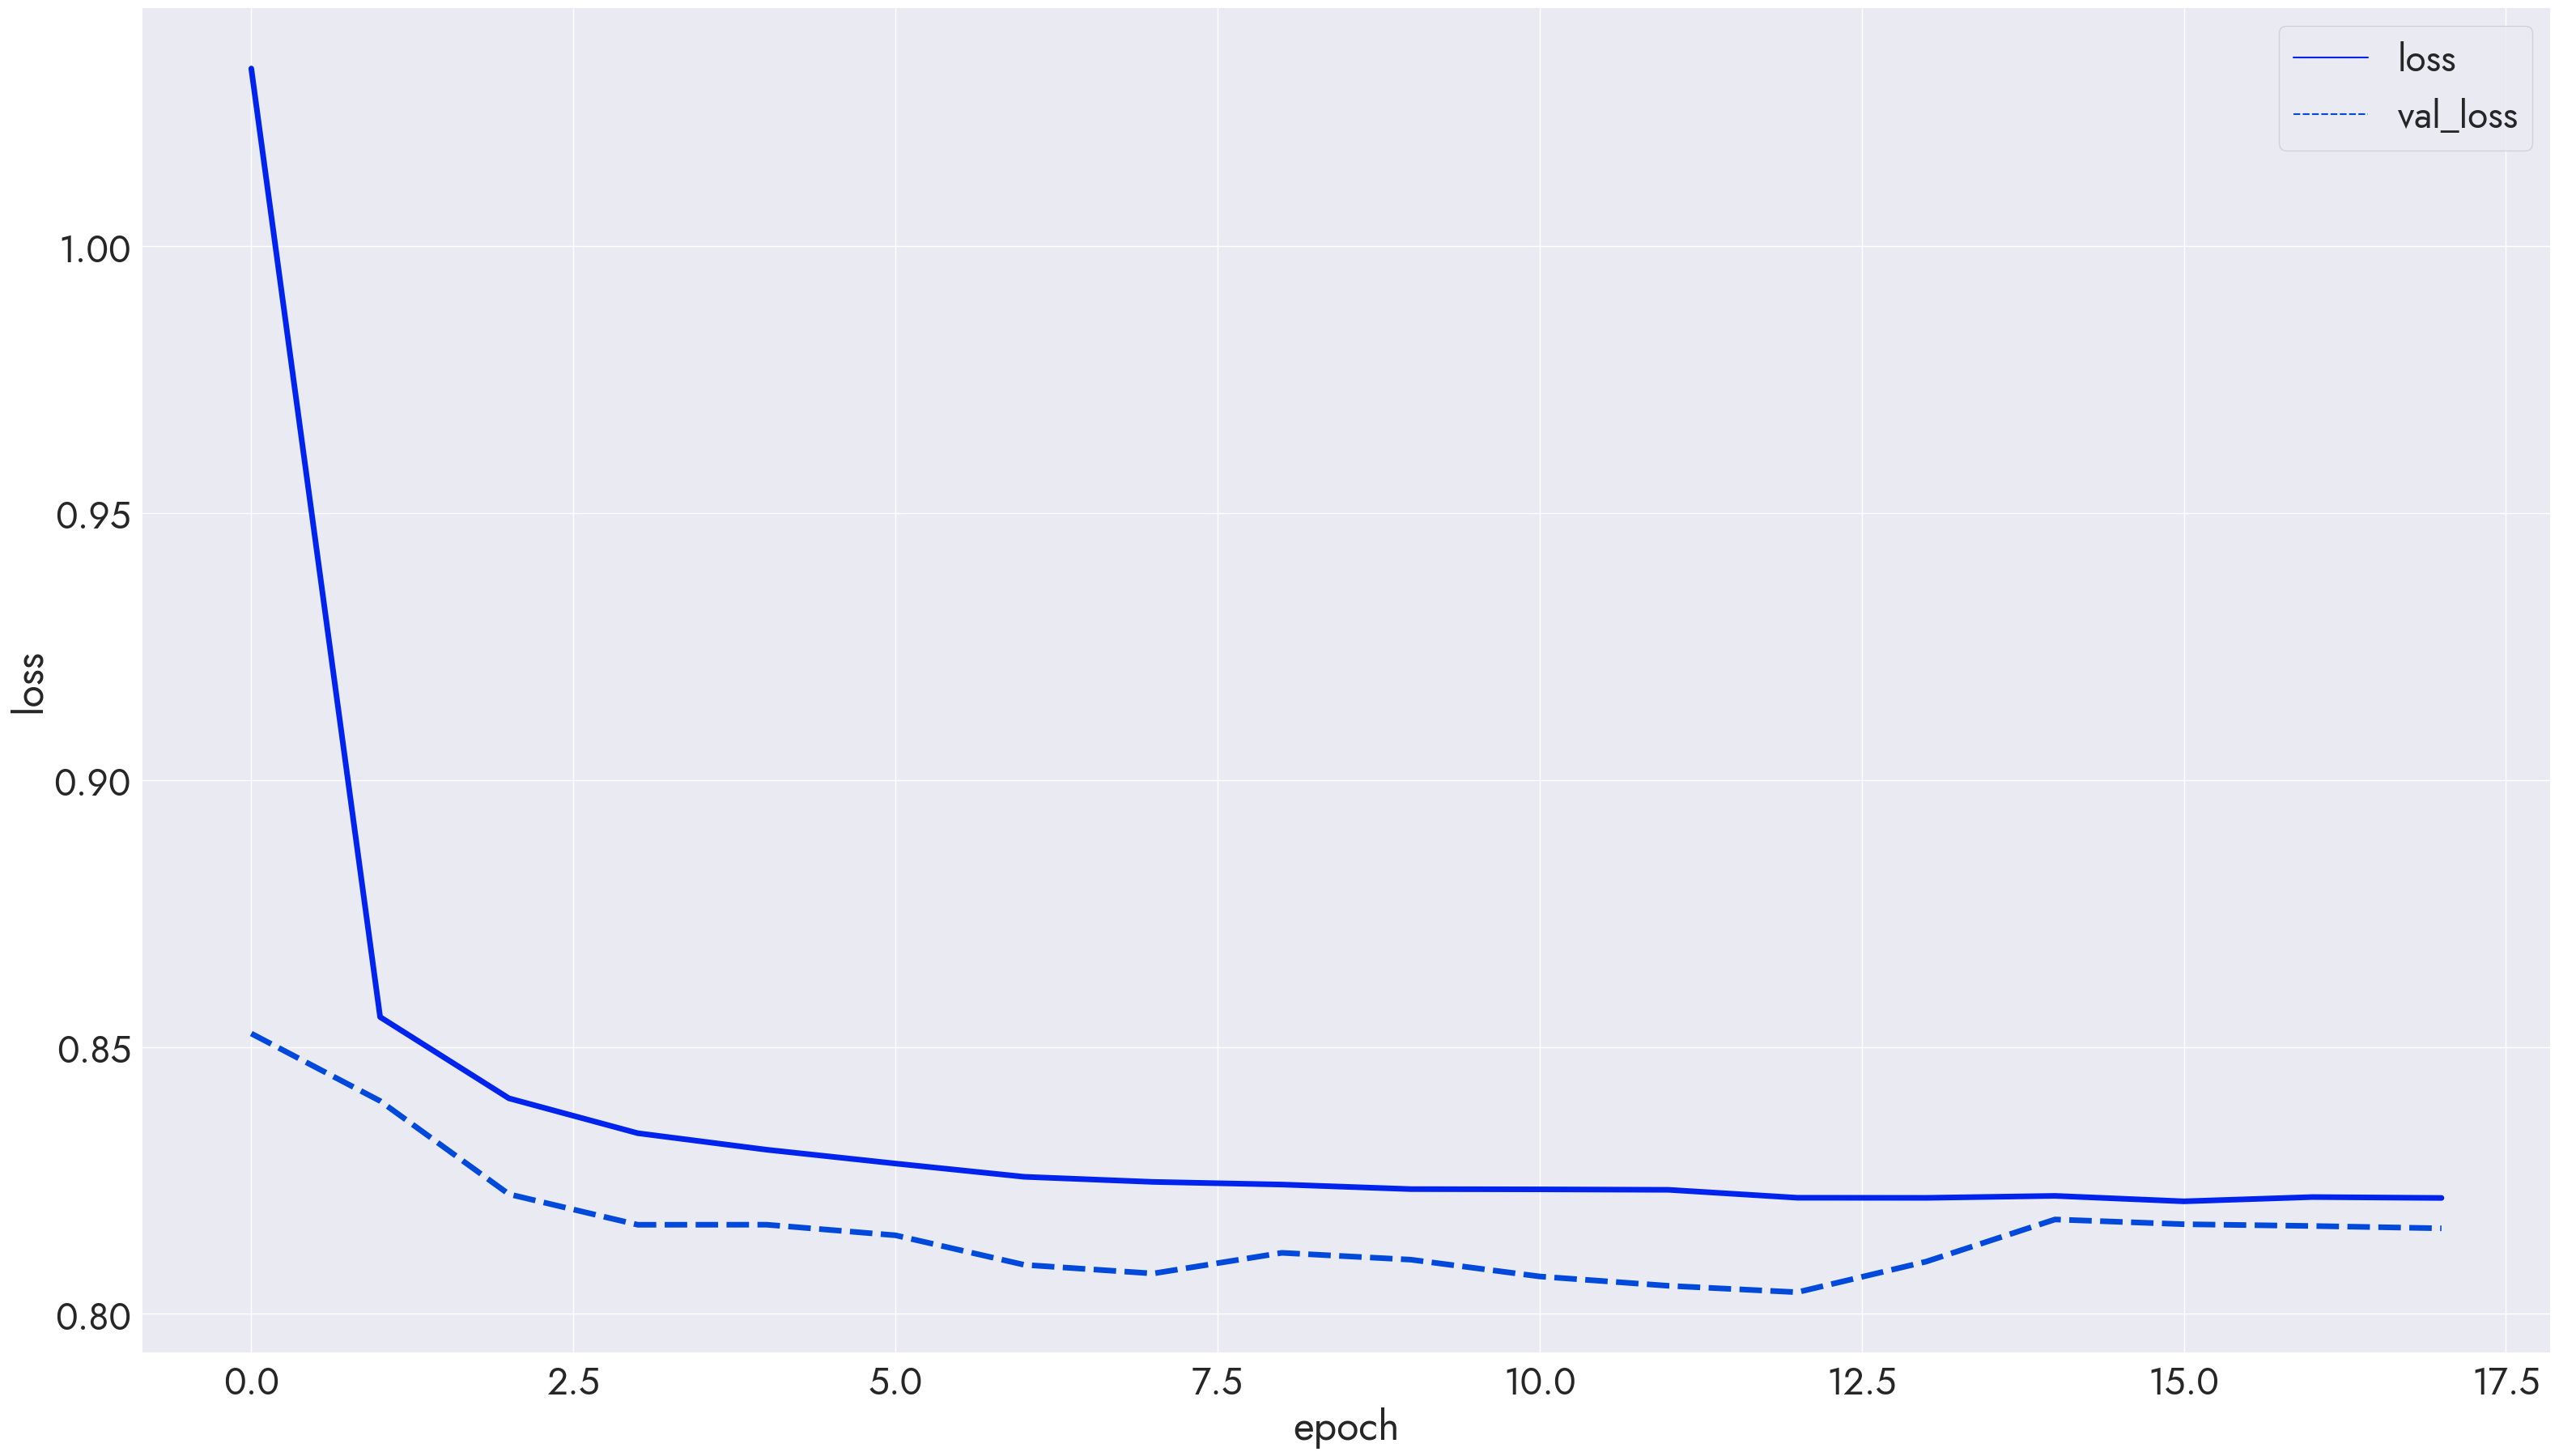

In [59]:
large_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[large_model.name])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('epoch')
large_plot_history.set_ylabel('loss');

In [60]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{large_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [61]:
large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

2500/2500 - 9s - loss: 0.8010 - accuracy: 0.6820 - 9s/epoch - 4ms/step


In [62]:
test_results[large_model.name] = large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

625/625 - 2s - loss: 0.8025 - accuracy: 0.6825 - 2s/epoch - 4ms/step


Сохраним модель:

In [63]:
large_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{large_model.name}')

2023-05-28 20:04:30.397244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-28 20:04:30.421093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-28 20:04:30.713162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-28 20:04

INFO:tensorflow:Assets written to: model/merged/fixed/fixed_large/assets


2023-05-28 20:04:31 - tensorflow - INFO - Assets written to: model/merged/fixed/fixed_large/assets


### finally
Выберем лучшую модель и проанализируем её предсказательные возможности.

Визуализируем график изменения точности предсказаний полученных моделей:

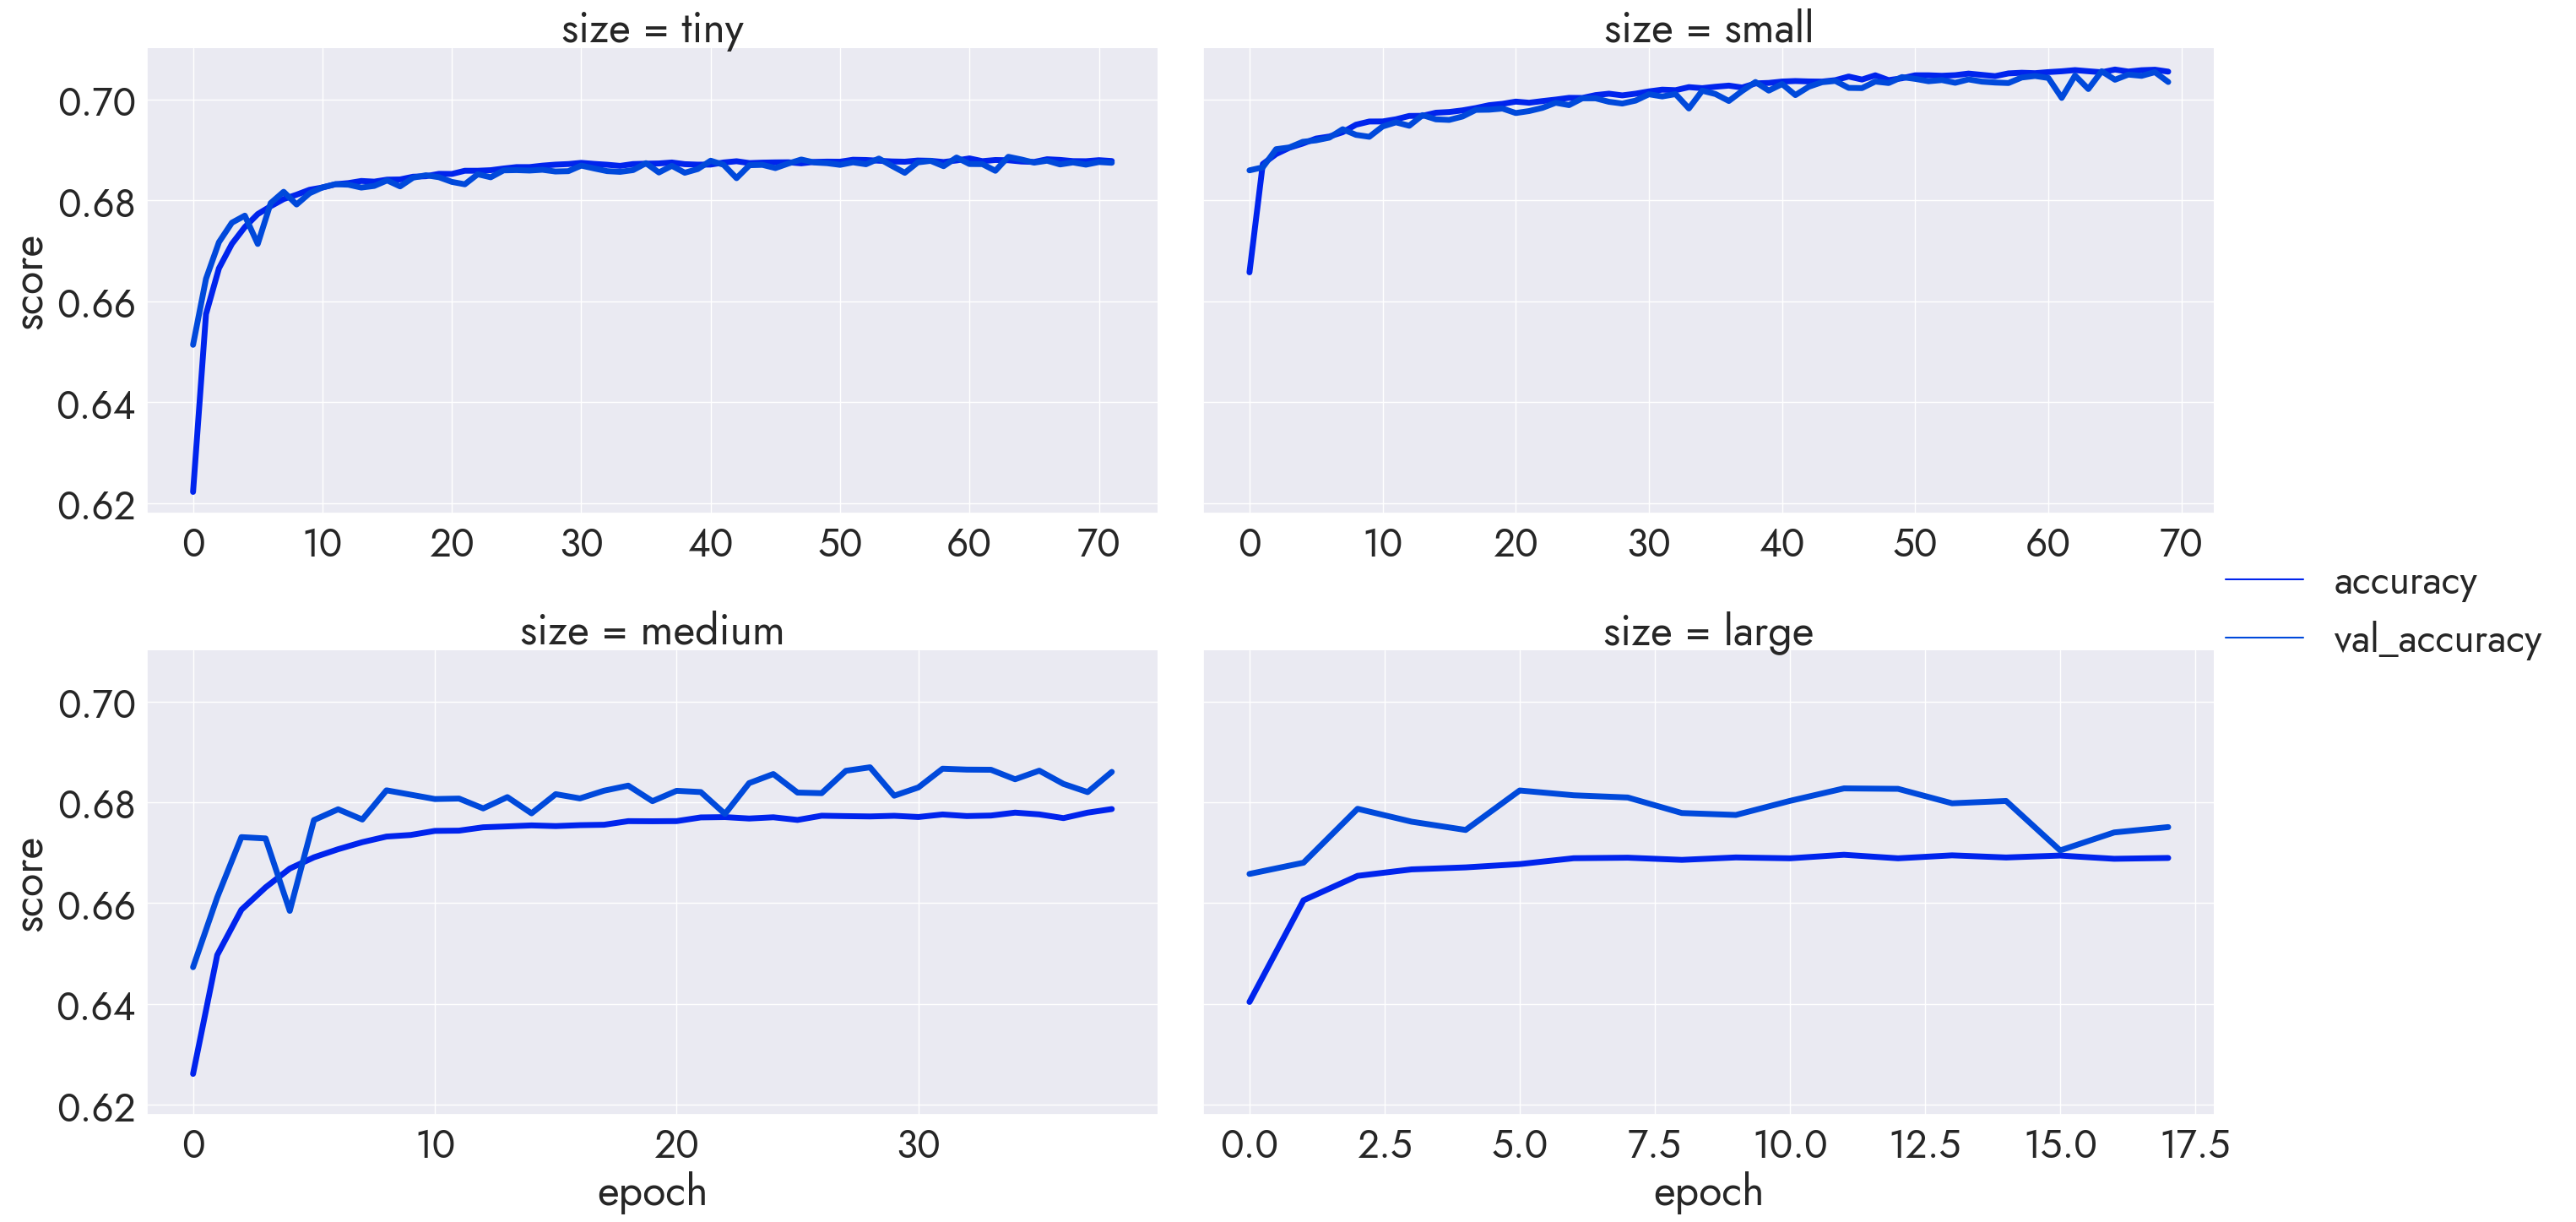

In [64]:
dnn_grid_history = sns.FacetGrid(
    data=(
        pd.concat(
            [pd.DataFrame(train_history)[['accuracy', 'val_accuracy']].stack() for train_history in train_histories.values()],
            keys=train_histories.keys(), names=['size', 'epoch', 'type'])
        .reset_index(level=['size'])
        .rename(columns={0: 'score'})
    ),
    col='size', col_wrap=2,
    height=FIG_SIZE[0] / 5, aspect=FIG_SIZE[0] / FIG_SIZE[1], sharex=False
)

dnn_grid_history.map_dataframe(sns.lineplot, 'epoch', 'score', hue='type', linewidth=5)
dnn_grid_history.add_legend();

In [65]:
dnn_grid_history.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_dnn.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний:

In [66]:
dnn_model_results = pd.DataFrame(test_results, index=['test_loss', 'test_accuracy'])

dnn_model_results

,tiny,small,medium,large
test_loss,0.730594,0.678849,0.763886,0.802533
test_accuracy,0.688444,0.705319,0.685956,0.682469


In [67]:
dnn_model = small_model

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [68]:
test_predict = dnn_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

625/625 - 2s - 2s/epoch - 3ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных:

In [69]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0)

Рассмотрим распределение предсказаний модели по группам:

In [70]:
dnn_dist = pd.DataFrame(sklearn.metrics.confusion_matrix(test_df['group'], pd.from_dummies(pd.DataFrame(test_predict)).astype('int8')),
                        index=groups, columns=groups)
dnn_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,28922,8601,1849,538
Lower-middle income,8954,22948,6142,1999
Upper-middle income,3224,4565,26179,6130
High income,230,1085,3832,34802


Выведем данную таблицу на тепловую карту:

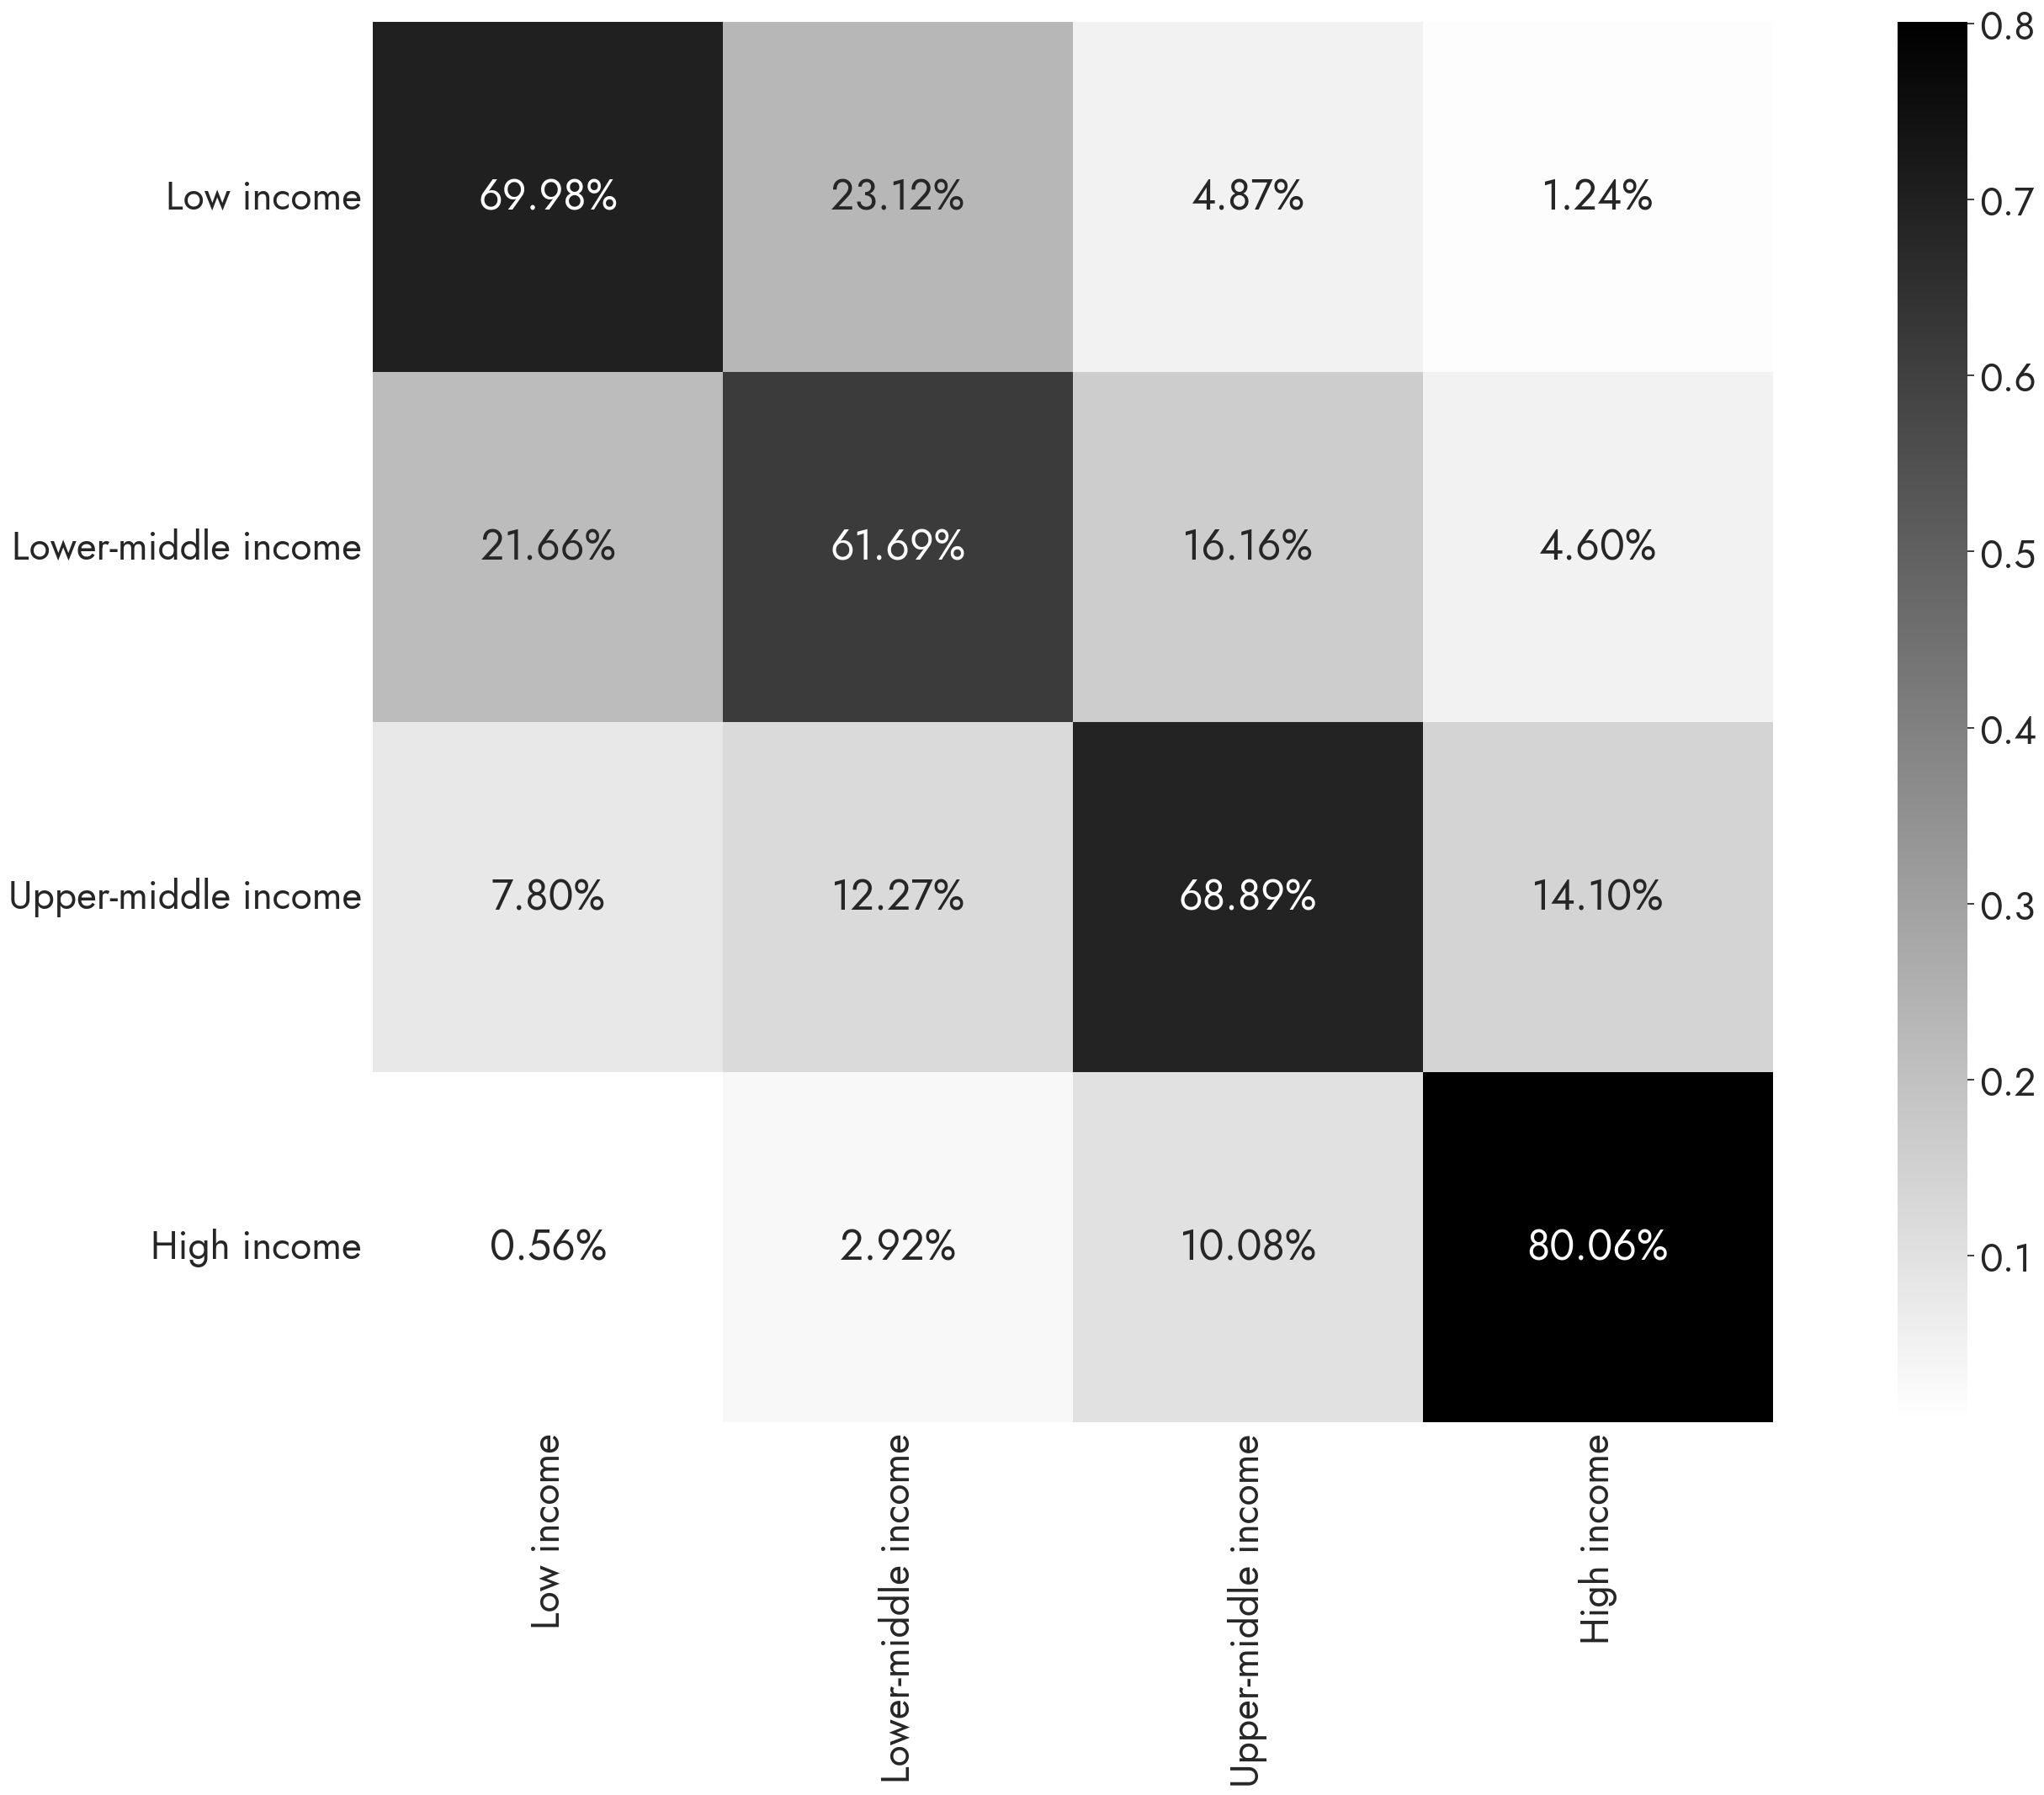

In [71]:
dnn_plot_dist = sns.heatmap(dnn_dist / dnn_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

dnn_plot_dist.set_xlabel(None);

In [72]:
dnn_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_dnn.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Визуализируем распределение ошибок в модели:

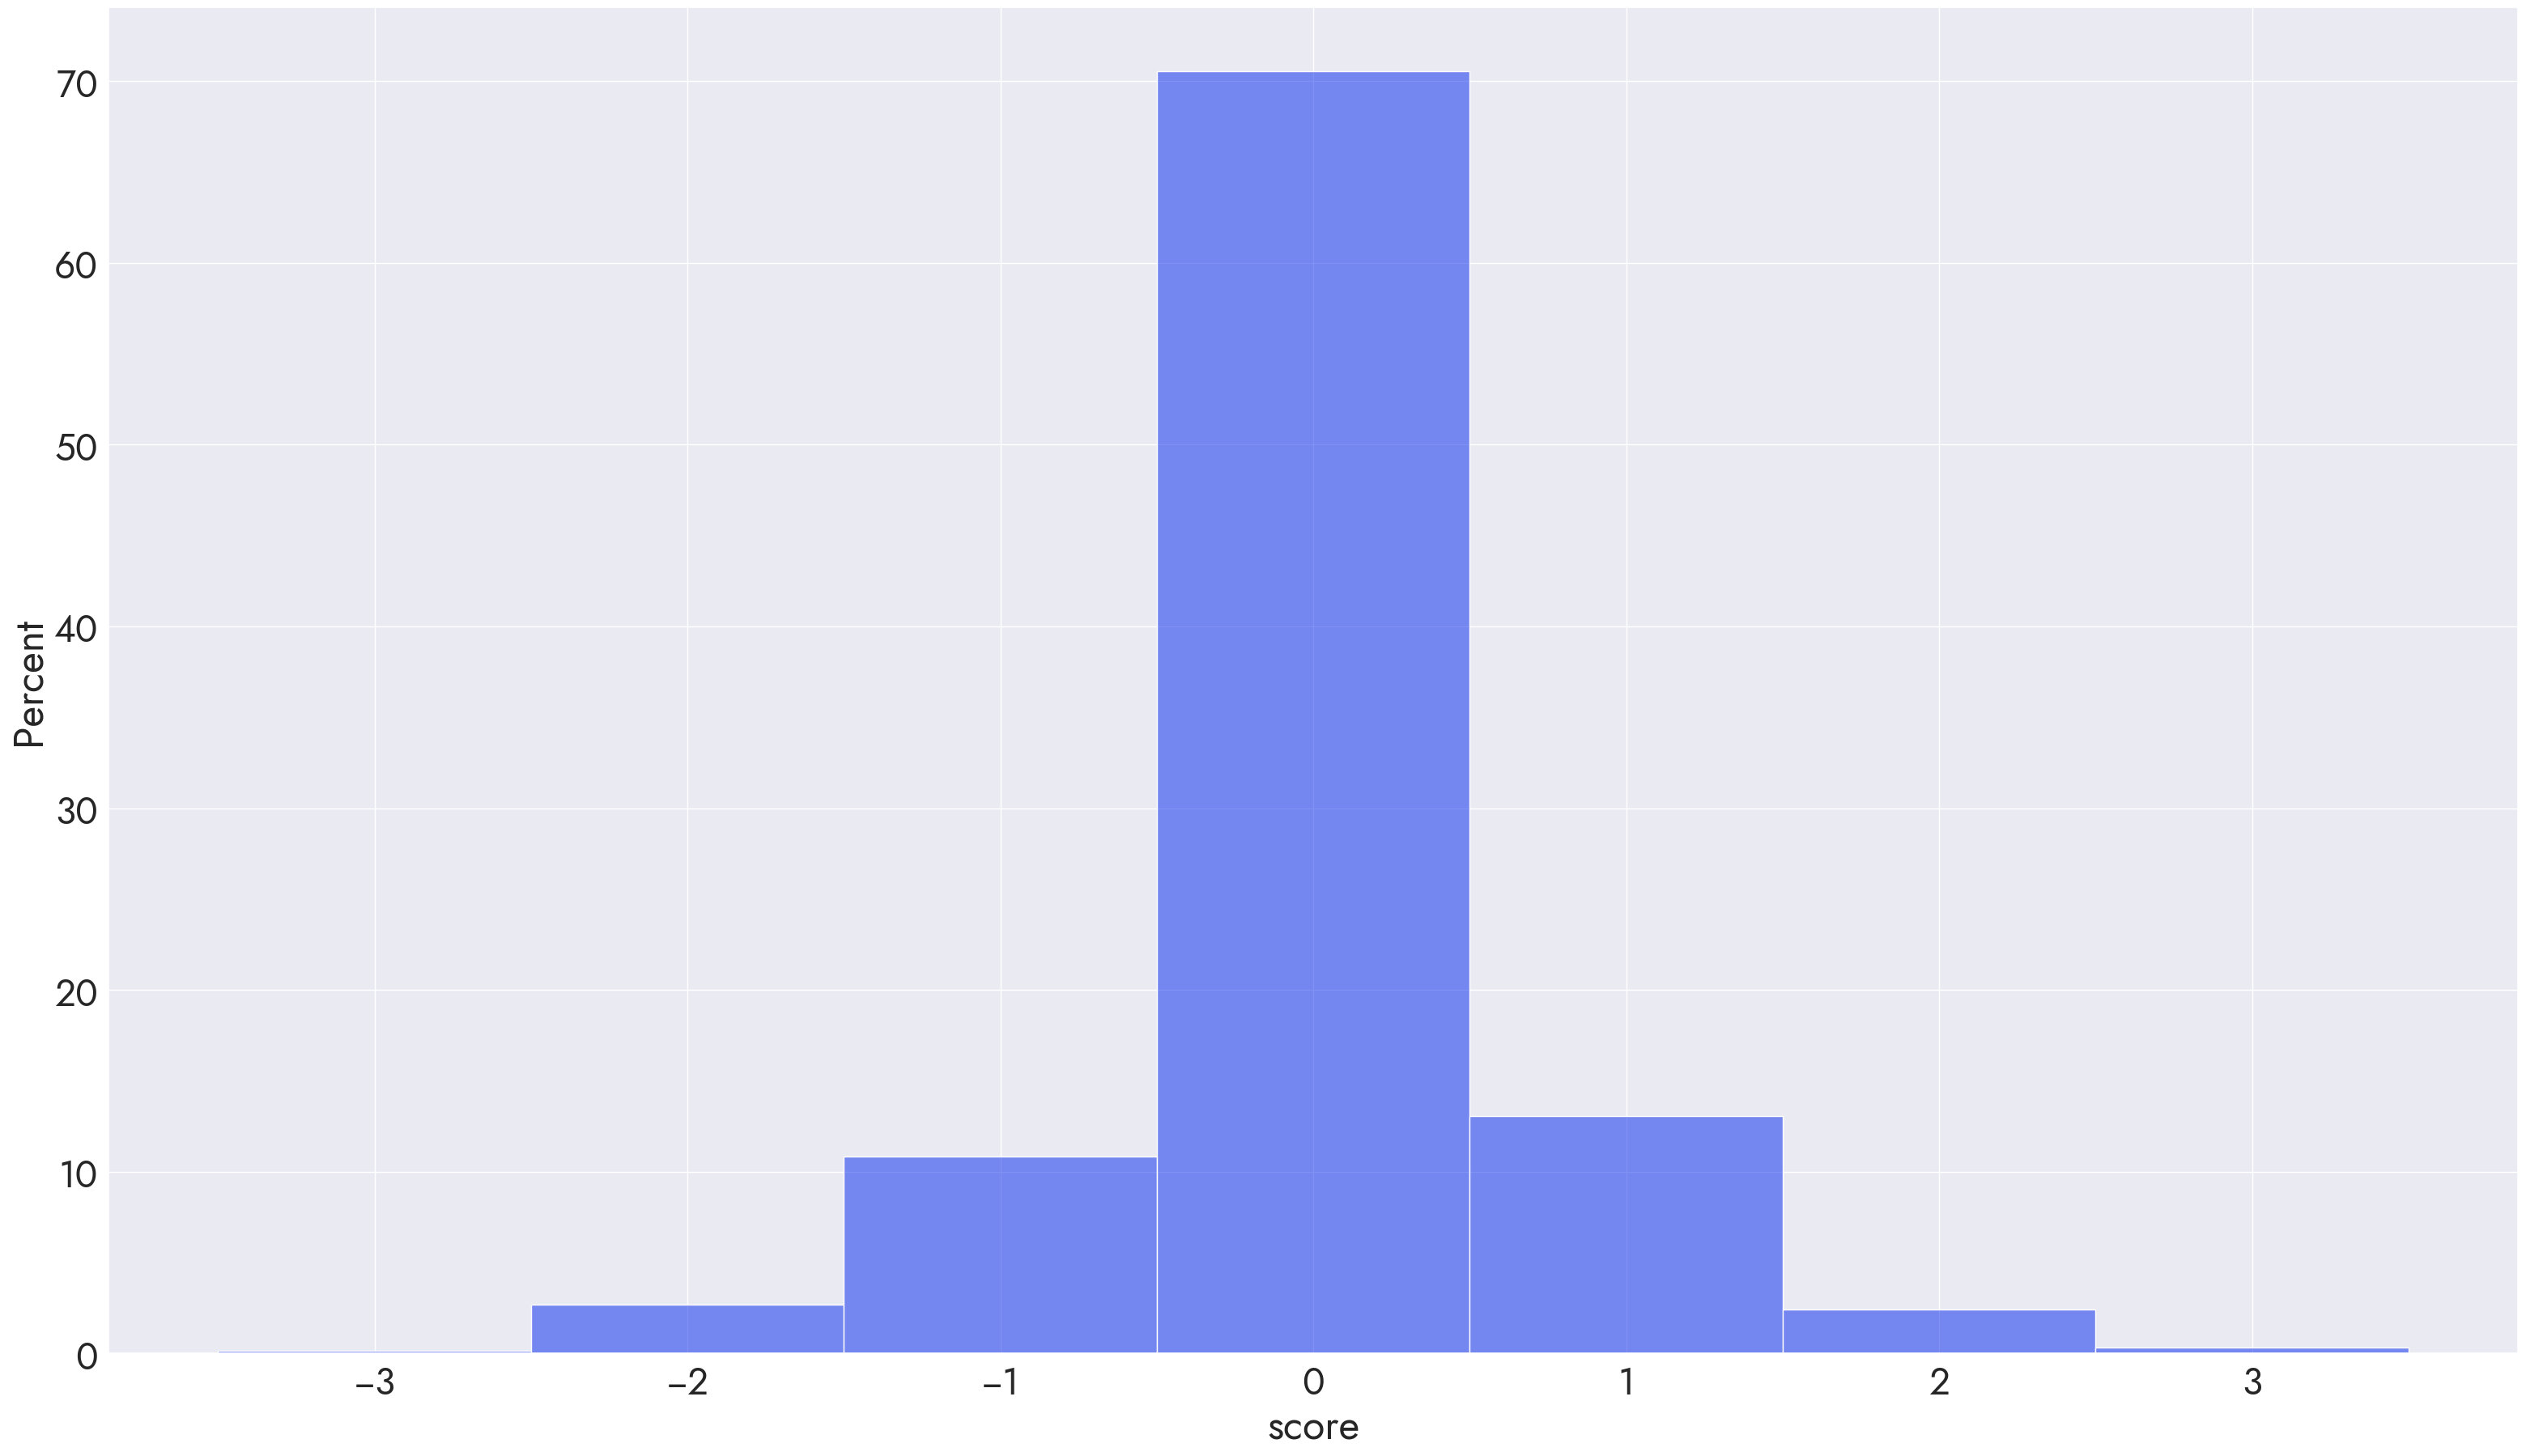

In [73]:
dnn_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)),
                                 stat='percent', legend=False, discrete=True)

dnn_plot_mistakes.set_xlabel('mistake')
dnn_plot_mistakes.set_xlabel('score');

In [74]:
dnn_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_dnn.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.